# Machine Learning for Complete Intersection Calabi-Yau Manifold

In the framework of String Theory, we apply machine learning (ML) techniques for the prediction of the Hodge numbers of Complete Intersection Calabi-Yau (CICY) 3-folds. The relevant quantities are therefore $h_{11}$ and $h_{21}$ which can be predicted starting from the configuration matrices of known manifolds.

We will use both unsupervised and supervised algorithms to produce an engineered dataset to improve the prediction abilities of different algorithms. We use libraries such as [_Scikit-learn_](https://scikit-learn.org/stable/) and [_XGBoost_](https://xgboost.readthedocs.io/en/latest/) in order to fit the data and [_Scikit-optimize_](https://scikit-optimize.github.io/stable/) for hyperparameter optimization. For the neural network analysis we use [Tensorflow](https://www.tensorflow.org/) and its _Keras_ module.

In [1]:
import sys

import matplotlib        as mpl
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import sklearn           as skl
import skopt             as sko
import tensorflow        as tf
import xgboost           as xgb

from tensorflow import keras
from tensorflow.keras import backend as K

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

print('Python version: {:d}.{:d}'.format(sys.version_info.major, sys.version_info.minor), flush=True)
print('Matplot version: {}'.format(mpl.__version__), flush=True)
print('Numpy version: {}'.format(np.__version__), flush=True)
print('Pandas version: {}'.format(pd.__version__), flush=True)
print('Scikit-learn version: {}'.format(skl.__version__), flush=True)
print('Scikit-optimize version: {}'.format(sko.__version__), flush=True)
print('Tensorflow version: {}'.format(tf.__version__), flush=True)
print('Keras version: {} (backend: {})'.format(keras.__version__, K.backend()), flush=True)
print('XGBoost version: {}'.format(xgb.__version__), flush=True)

# fix random_seed
RAND = 42
np.random.seed(RAND)
tf.random.set_seed(RAND)

Python version: 3.7
Matplot version: 3.2.1
Numpy version: 1.18.1
Pandas version: 1.0.3
Scikit-learn version: 0.22.2.post1
Scikit-optimize version: 0.7.4
Tensorflow version: 2.0.0
Keras version: 2.2.4-tf (backend: tensorflow)
XGBoost version: 0.90


Hardware specifications are as follow:

In [2]:
!echo "OS:  $(uname -o) - $(lsb_release -d| sed 's/^.*:\s*//g')"
!echo "CPU: $(lscpu| grep 'Model name'| sed 's/^.*:\s*//g')"
!echo "RAM: $(free --giga| awk '/^Mem/ {print $7}') GiB"
!echo "GPU: $(lspci | grep '3D controller' | sed 's/^.*controller:\s*//g')"

OS:  GNU/Linux - Arch Linux
CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
RAM: 11 GiB
GPU: NVIDIA Corporation GM108M [GeForce 940MX] (rev a2)


We also create a file logger to store debug information:

In [3]:
import logging
from os import path, rename
from time import strftime, gmtime

def create_logfile(filename, name='logger', level=logging.INFO):
    """Create a logfile and rotate old logs.
    
    Required arguments:
        filename: the name of the file or path to the log
        
    Optional arguments
        name:     the name of the log session
        level:    the level of the information stores
        
    Returns:
        the log
    """
    
    # get current time to rename strings
    ctime = strftime('.%Y%m%d.%H%M%S', gmtime())
    
    # rotate log if it already exists
    if path.isfile(filename):
        print('Rotating existing logs...', flush=True)
        rename(filename, filename + ctime)
    
    # get a logging session by name
    log = logging.getLogger(name + ctime)
    log.setLevel(level)
    
    # define format
    fmt = logging.Formatter('%(asctime)s --> %(levelname)s: %(message)s')
    
    # add the log file
    han = logging.FileHandler(filename=filename)
    han.setLevel(level)
    han.setFormatter(fmt)
    
    # add handler for standard output
    std = logging.StreamHandler(sys.stdout)
    std.setLevel(level)
    std.setFormatter(fmt)
    
    # create the output
    log.addHandler(han)
    log.addHandler(std)
    
    print('Created new log file!', flush=True)
    return log

def logprint(string, stream='info', logger=None):
    """Decides whether to print on the logger or the standard output.
    
    Required arguments:
        string: the string to print
    
    Optional arguments:
        stream: standard input (info) or standard error (error)
        logger: the logger (None for standard output/error)
    """
    
    if logger is not None:
        if stream == 'info':
            logger.info(string)
        elif stream == 'error':
            logger.error(string)
        else:
            logger.debug(string)
    else:
        if stream == 'info':
            sys.stdout.write(string)
        elif stream == 'error':
            sys.stderr.write(string)
        else:
            sys.stdout.write(string)

## Preparation and Tools

We first fetch the desired dataset and prepare the tools for the analysis. Specifically we need to:

1. define the names of the main directories and create them if non existent,
2. import the database,
3. create tools for visualisation and manipulation of the dataset.

Start from the directories and the name of the dataset to consider:

In [4]:
import logging
from os import makedirs

ROOT_DIR = '.'      # root directory
IMG_DIR  = 'img'    # image directory
MOD_DIR  = 'models' # directory of saved models
LOG_DIR  = 'log'    # directory for logs

# name of the dataset to be considered
DB_NAME = 'cicy3o'
DB_FILE = DB_NAME + '.h5'              # full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) # full path
DB_DIR  = 'original' if DB_NAME == 'cicy3o' else 'favourable' # subdir where to store images, models, logs

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR, DB_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR, DB_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR, DB_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)
    
# create logfile
logger = create_logfile(filename=path.join(LOG_PATH, DB_NAME + '.log'), name='CICY3', level=logging.INFO)

Rotating existing logs...
Created new log file!


Then import the database:

In [5]:
import tarfile

from urllib import request as rq

URL_ROOT = 'http://www.lpthe.jussieu.fr/~erbin/files/data/'
TAR_FILE = DB_NAME + '_data.tar.gz'
TAR_PATH = path.join(ROOT_DIR, TAR_FILE)

if not path.isfile(TAR_PATH): # fetch file only if not already downloaded
    logprint('Fetching dataset...\n', logger=logger)
    _, message = rq.urlretrieve(URL_ROOT + TAR_FILE, TAR_PATH)
    logger.info('Dataset fetched!')
    
if path.isfile(TAR_PATH):
    logprint('Extracting dataset from tarball...', logger=logger)
    with tarfile.open(TAR_PATH, 'r') as tar:
        tar.extract(DB_FILE, path=ROOT_DIR)
    logprint('Dataset extracted!', logger=logger)
else:
    logprint('Tarball non available: cannot extract tarball!', stream='error', logger=logger)

2020-04-01 17:28:23,047 --> INFO: Extracting dataset from tarball...
2020-04-01 17:28:23,127 --> INFO: Dataset extracted!


We then prepare to load the dataset and prepare for the visualisation analysis:

In [6]:
import pandas as pd

def load_dataset(filepath, mode='hdf5', shuffle=False, random_state=None, logger=None):
    """Load a dataset given the path and the format.
    
    Required arguments:
        filepath: the path of the file
        
    Optional arguments:
        mode:         the format of the file
        shuffle:      whether to shuffle the file
        random_state: the seed of the random generator
        logger:       the logging session (None for standard output)
        
    Returns:
        the dataset
    """
    
    if path.isfile(filepath):
        logprint('Reading database...', logger=logger)
        if mode == 'hdf5':
            df = pd.read_hdf(filepath)
        elif mode == 'csv':
            df = pd.read_csv(filepath)
        logprint('Database loaded!', logger=logger)
    else:
        logprint('Database is not available: cannot load the database!', stream='error', logger=logger)
        
    # shuffle the dataframe
    if shuffle and random_state is not None:
        logprint('Shuffling database...', logger=logger)
        df = skl.utils.shuffle(df, random_state=random_state)
        logprint('Database shuffled!', logger=logger)
        
    return df

We then define some functions we can use to extract and manipulate the database:

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

# remove the outliers from a Pandas dataset
class RemoveOutliers(BaseEstimator, TransformerMixin):
    """Remove outlying data given a dataset and a dictionary containing the intervals for each class.
    
    E.g.: if the two classes are 'h11' and 'h21', the dictionary will be: {'h11': [1, 16], 'h21': [1, 86]}.
    
    Public methods:
        fit:           unused method
        transform:     remove data outside the given interval
        fit_transform: equivalent to transform(fit(...))
    """

    def __init__(self, filter_dict=None):
        """Constructor of the class.
        
        Optional arguments:
            filter_dict: the intervals to retain in the data
        """
        
        self.filter_dict = filter_dict

    def fit(self, X, y=None):
        """Unused method.
        """

        return self

    def transform(self, X):
        """Transform the input by deleting data outside the interval
        
        Required arguments:
            X: the dataset
            
        Returns:
            the transformed dataset
        """

        x = X.copy() # avoid overwriting

        if self.filter_dict is not None:
            for key in self.filter_dict:
                x = x.loc[x[key] >= self.filter_dict[key][0]]
                x = x.loc[x[key] <= self.filter_dict[key][1]]

        return x

# extract the tensors from a Pandas dataset
class ExtractTensor(BaseEstimator, TransformerMixin):
    """Extract a dense tensor from sparse input from a given dataset.
    
    Public methods:
        fit:           unused method
        transform:     extract dense tensor
        fit_transform: equivalent to transform(fit(...))
        get_shape:     compute the shape of the tensor
    """

    def __init__(self, flatten=False, shape=None):
        """Constructor of the class.
        
        Optional arguments:
            flatten: whether to flatten the output or keep the current shape
            shape:   force the computation with a given shape
        """

        self.flatten = flatten
        self.shape   = shape

    def fit(self, X, y=None):
        """Unused method.
        """

        return self

    def transform(self, X):
        """Compute the dense equivalent of the sparse input.
        
        Required arguments:
            X: the dataset
            
        Returns:
            the transformed input
        """

        x = X.copy() # avoid overwriting
        if self.shape is None:
            self.shape = x.apply(np.shape).max() # get the shape of the tensor

        if len(self.shape) > 0: # apply this to vectors and tensors
            offset = lambda s : [ (0, self.shape[i] - np.shape(s)[i]) for i in range(len(self.shape)) ]
            x      = x.apply(lambda s: np.pad(s, offset(s), mode='constant'))

        if self.flatten and len(self.shape) > 0:
            return list(np.stack(x.apply(np.ndarray.flatten).values))
        else:
            return list(np.stack(x.values))

    def get_shape(self):
        """Compute the shape of the tensor.
        
        Returns:
            the shape of the tensor
        """
        
        return self.shape

# get the accuracy (possibly after rounding)
def accuracy_score(y_true, y_pred, rounding=np.rint):
    """Compute the accuracy of the predictions after rounding.
    
    Required arguments:
        y_true: true values
        y_pred: predicted values
        
    Optional arguments:
        rounding: the Numpy function for rounding the predictions
    """

    assert np.shape(y_true)[0] == np.shape(y_pred)[0] # check if same length
    
    # if same length then proceed
    accuracy = 0
    if rounding is not None:
        for n in range(np.shape(y_true)[0]):
            accuracy = accuracy + 1 \
                       if int(y_true[n]) == int(rounding(y_pred[n])) \
                       else accuracy
    else:
        for n in range(np.shape(y_true)[0]):
            accuracy = accuracy + 1 \
                       if y_true[n] == y_pred[n] \
                       else accuracy
    return accuracy / np.shape(y_true)[0]

# get the error difference (possibly after rounding)
def error_diff(y_true, y_pred, rounding=np.rint):
    """Compute the error difference between true values and predictions (positive values are overestimate and viceversa).
    
    Required arguments:
        y_true: true values
        y_pred: predicted values
        
    Optional arguments:
        rounding: the Numpy function for rounding the predictions
    """

    assert np.shape(y_true)[0] == np.shape(y_pred)[0] # check if same length

    # if same length then proceed
    err = y_true - rounding(y_pred)
    return np.array(err).astype(np.int8)

# print *SearchCV scores
def gridcv_score(estimator, rounding=np.rint, logger=None):
    """Print scores given by cross-validation and optimisation techniques.
    
    Required arguments:
        estimator: the estimator to be evaluated
        
    Optional arguments:
        rounding: the Numpy function for rounding the predictions
        logger:   the logging session (None for standard output)
    """
    
    best_params = estimator.best_params_              # get best parameters
    df          = pd.DataFrame(estimator.cv_results_) # dataframe with CV res.
    
    cv_best_res = df.loc[df['params'] == best_params] # get best results
    accuracy    = cv_best_res.loc[:, 'mean_test_score'].values[0]
    std         = cv_best_res.loc[:, 'std_test_score'].values[0]
    
    logprint('Best parameters: {}'.format(best_params), logger=logger)
    logprint('Accuracy ({}) of cross-validation: ({:.3f} ± {:.3f})%'.format(rounding.__name__, accuracy*100, std*100), logger=logger)
    
# print the accuracy of the predictions
def prediction_score(estimator, X, y, use_best_estimator=False, rounding=np.rint, logger=None):
    """Print the accuracy of the predictions.
    
    Required arguments:
        estimator: the estimator to be used for the predictions
        X: the features
        y: the labels (actual values)
        
    Optional arguments:
        use_best_estimator: whether to use the estimator.best_estimator_ or just estimator
        rounding: the Numpy function for rounding the predictions
        logger:   the logging session (None for standard output)
    """
    
    if use_best_estimator:
        estimator = estimator.best_estimator_
    
    accuracy = accuracy_score(y, estimator.predict(X), rounding=rounding)
    logprint('Accuracy ({}) of the predictions: {:.3f}%'.format(rounding.__name__, accuracy*100), logger=logger)

We then use _Matplotlib_ to plot the data. We define a few functions which we can use during the analysis:

In [8]:
# set label sizes
%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# set building block sizes for the plot
mpl_width  = 6
mpl_height = 5

# save the current figure
def save_fig(filename, tight_layout=True, extension='png', resolution=96, logger=None):
    """Save current figure to file.
    
    Required arguments:
        filename: the name of the file where to save the figure (without extension)
        
    Optional arguments:
        tight_layout: whether to use the tight_layout
        extension:    extension of the file to use
        resolution:   resolution of the file
        logger:       the logging session (None for standard output)
    """

    filename = path.join(IMG_PATH, filename + '.' + extension)
    if tight_layout:
        plt.tight_layout()

    logprint('Saving {}...'.format(filename), logger=logger)
    plt.savefig(filename, format=extension, dpi=resolution)
    logprint('Saved {}!'.format(filename), logger=logger)

# get a generator to count the occurrencies
def get_counts(df, label, feature):
    """Generator to produce the count of unique occurrencies of the data.
    
    Required arguments:
        df:      the Pandas dataframe
        label:   the label to consider
        feature: the feature to consider
        
    Yields:
        [ unique feature, unique value, counts ]
    """

    for n in np.sort(df[feature].unique()):
        uniques, counts = np.unique(df[label].loc[df[feature] == n].values, return_counts=True)
        for u, c in np.c_[uniques, counts]:
            yield [ n, u, c ]

# plot histogram of occurrencies
def count_plot(ax, data, title=None, xlabel=None, ylabel='N',
               legend=None, xlog=False, ylog=False, binstep=5,
               **kwargs):
    """Plot histogram of occurrencies (e.g.: frequency plot).
    
    Required arguments:
        ax:   the subplot ax where to plot data
        data: the data to plot
        
    Optional arguments:
        title:    the title of the plot
        xlabel:   the label of the x axis
        ylabel:   the label of the y axis
        legend:   the label for the legend in the plot
        xlog:     whether to use the log scale on the x axis
        ylog:     whether to use the log scale on the y axis
        binstep:  the distance between adjacent bins
        **kwargs: additional arguments to pass to plt.hist
    """

    min_tick = np.min(data) if np.min(data) > -100 else -100 # set a MIN cut
    max_tick = np.max(data) if np.max(data) < 100  else 100  # set a MAX cut

    ax.grid(alpha=0.2)                   # create a grid
    ax.set_title(title)                  # set title
    ax.set_xlabel(xlabel)                # set a label for the x axis
    ax.set_ylabel(ylabel)                # set a label for the y axis
    ax.set_xticks(np.arange(min_tick,    # set no. of ticks in the x axis
                            max_tick,
                            step=binstep
                           )
                 )

    if xlog:                             # use log scale in x axis if needed
        ax.set_xscale('log')
    if ylog:                             # use log scale in y axis if needed
        ax.set_yscale('log')

    ax.hist(data,                        # create histogram using 'step' funct.
            histtype='step',
            label=legend,
            **kwargs)

    if legend is not None:               # add legend
        ax.legend(loc='best')

    return ax

# plot labeled features and their values
def label_plot(ax, data, title=None, xlabel=None, ylabel='values',
               legend=None, xlog=False, ylog=False, binstep=1,
               **kwargs):
    """Plot values of labelled data (e.g.: variable ranking).
    
    Required arguments:
        ax:   the subplot ax where to plot data
        data: the data to plot
        
    Optional arguments:
        title:    the title of the plot
        xlabel:   the label of the x axis
        ylabel:   the label of the y axis
        legend:   the label for the legend in the plot
        xlog:     whether to use the log scale on the x axis
        ylog:     whether to use the log scale on the y axis
        binstep:  the distance between adjacent bins
        **kwargs: additional arguments to pass to plt.plot
    """

    labels      = [f[0] for f in data]   # labels vector
    importances = [f[1] for f in data]   # importances vector
    length      = len(labels)            # length of the labels vector
    
    ax.grid(alpha=0.2)                   # create a grid
    ax.set_title(title)                  # set title
    ax.set_xlabel(xlabel)                # set a label for the x axis
    ax.set_ylabel(ylabel)                # set a label for the x axis

    ax.set_xticks(np.arange(length,      # set no. of ticks in the x axis
                            step=binstep
                           )
                 )
    ax.set_xticklabels(labels,           # set name of labels of the x axis
                       ha='right',       # horizontal alignment
                       rotation=45       # rotation of the labels
                      )

    if xlog:                             # use log scale in x axis if needed
        ax.set_xscale('log')
    if ylog:                             # use log scale in y axis if needed
        ax.set_yscale('log')

    ax.plot(np.arange(length),           # plot data
            importances,
            label=legend,
            **kwargs)

    if legend is not None:               # add legend
        ax.legend(loc='best')

    return ax

# plot the correlation matrix of a Pandas dataframe
def mat_plot(ax, matrix, labels, label='correlation matrix', **kwargs):
    """Plot the correlation matrix of a given dataframe.
    
    Required arguments:
        ax:     the subplot ax where to plot data
        matrix: the matrix to plot
        labels: the labels to show with the matrix
        
    Optional arguments:
        label:    the label to use for the colour bar
        **kwargs: additional arguments to pass to plt.matshow
    """
    
    ax.set_xticks(np.arange(len(labels), # set ticks for x axis
                  step=1)
                 )
    ax.set_xticklabels([''] + labels,    # set the name of the ticks
                       rotation=90
                      )

    ax.set_yticks(np.arange(len(labels), # set ticks for y axis
                  step=1)
                 )
    ax.set_yticklabels([''] + labels)    # set the name of the ticks
                    
    matshow = ax.matshow(matrix,         # show the matrix
                         vmin=-1.0,
                         vmax=1.0,
                         **kwargs
                        )
                                
    cbar = ax.figure.colorbar(matshow,   # create the colour bar
                              ax=ax,
                              fraction=0.05,
                              pad=0.05
                             )
    cbar.ax.set_ylabel(label,            # show the colour bar
                       va='bottom',      # vertical alignment
                       rotation=-90)     # rotation of the label

    return ax

# plot a scatter plot with colours and sizes
def scatter_plot(ax, data, title=None, xlabel=None, ylabel=None,
                 legend=None, xlog=False, ylog=False,
                 colour=True, size=True, colour_label='N', size_leg=0,
                 **kwargs):
    """Scatter plot of occurrencies with colour and size codes.
    
    Required arguments:
        ax:   the subplot ax where to plot data
        data: the data to plot
        
    Optional arguments:
        title:        the title of the plot
        xlabel:       the label of the x axis
        ylabel:       the label of the y axis
        legend:       the label for the legend in the plot
        xlog:         whether to use the log scale on the x axis
        ylog:         whether to use the log scale on the y axis
        colour:       whether to use colour codes
        size:         whether to use entries of different size
        colour_label: label to use for the colour code
        size_leg:     length of the legend of the size code
        **kwargs:     additional arguments to pass to plt.scatter
    """

    ax.grid(alpha=0.2)                   # create  a grid
    ax.set_xlabel(xlabel)                # set labels for the x axis
    ax.set_ylabel(ylabel)                # set labels for the y axis
    ax.set_title(title)                  # set title

    if xlog:                             # use log scale in x axis if needed
        ax.set_xscale('log')
    if ylog:                             # use log scale in y axis if needed
        ax.set_yscale('log')

    if colour:                           # create the plot with size and colours
        if size:
            scat = ax.scatter(data[0], data[1], s=data[2], c=data[2], **kwargs)
        else:
            scat = ax.scatter(data[0], data[1], c=data[2], **kwargs)
        cbar = ax.figure.colorbar(scat, ax=ax)
        cbar.ax.set_ylabel(colour_label, rotation=-90, va='bottom')
    else:
        if size:
            scat = ax.scatter(data[0], data[1], s=data[2], **kwargs)
        else:
            scat = ax.scatter(data[0], data[1], **kwargs)

    scat.set_label(legend)               # set label of the plot
    if size_leg:                         # add the size legend if needed
        handles, labels = scat.legend_elements('sizes', num=size_leg)
        ax.legend(handles, labels, loc='lower center',
                  bbox_to_anchor=(0.5,-0.3), ncol=len(handles),
                  fontsize='medium', frameon=False)

    if legend:                           # show the legend
        ax.legend(loc='best')

    return ax

# plot a series with trivial x label
def series_plot(ax, data, title=None, xlabel='series', ylabel=None,
                legend=None, xlog=False, ylog=False,
                step=False, std=False,
                **kwargs):
    """Plot a series of data with ordered x axis (e.g.: epoch series).
    
    Required arguments:
        ax:   the subplot ax where to plot data
        data: the data to plot
        
    Optional arguments:
        title:    the title of the plot
        xlabel:   the label of the x axis
        ylabel:   the label of the y axis
        legend:   the label for the legend in the plot
        xlog:     whether to use the log scale on the x axis
        ylog:     whether to use the log scale on the y axis
        step:     whether to use a step function for the plot
        std:      highlight the strip of the standard deviation
        **kwargs: additional arguments to pass to plt.step or plot.plot
    """

    ax.grid(alpha=0.2)                   # create the grid
    ax.set_title(title)                  # set the title
    ax.set_xlabel(xlabel)                # set labels for the x axis
    ax.set_ylabel(ylabel)                # set labels for the y axis

    if xlog:                             # use log scale in the x axis if needed
        ax.set_xscale('log')
    if ylog:                             # use log scale in the y axis if needed
        ax.set_yscale('log')

    series = np.arange(len(data))        # create trivial x axis data
    if step:                             # create the plot
        ax.step(series, data, label=legend, **kwargs)
    else:
        ax.plot(series, data, label=legend, **kwargs)

    if std:                              # show coloured strip with std
        ax.fill_between(series,
                        data + np.std(data),
                        data - np.std(data),
                        alpha=0.2)

    if legend is not None:               # show the legend
        ax.legend(loc='best')

    return ax

Before going further we also set the **memory growth** of the GPU RAM in order to avoid memory issues:

In [9]:
# get the list of installed GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) # set memory growth
            
        # get the list of logical devices (GPUs)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        logprint('GPU setup: {:d} physical GPUs, {:d} logical GPUs.'.format(len(gpus), len(logical_gpus)), logger=logger)
    except RuntimeError as e:
        logprint(e, stream='error', logger=logger)
else:
    logprint('No GPUs in the setup!', stream='error', logger=logger)

2020-04-01 17:28:23,503 --> INFO: GPU setup: 1 physical GPUs, 1 logical GPUs.


## Data Visualisation

We first visualise the data inside the dataframe. We focus on manifolds which are not direct products of other spaces (i.e. we consider only entries with `isprod = 0`) and consider $h_{11} \in [ 1, 16 ]$ and $h_{21} \in [ 1, 86 ]$. We show the distribution of the labels both in their frequency and with respect to a few of the features.

In [10]:
# load the database
df = load_dataset(DB_PATH, shuffle=False, logger=logger)

2020-04-01 17:28:23,509 --> INFO: Reading database...
2020-04-01 17:28:23,845 --> INFO: Database loaded!


As a reference we print the name of the columns and their respective _dtypes_:

In [11]:
df.dtypes

c2                 object
euler               int16
h11                 int16
h21                 int16
matrix             object
redun              object
size               object
num_cp               int8
num_eqs             int64
dim_cp             object
min_dim_cp          int64
max_dim_cp          int64
mean_dim_cp       float64
median_dim_cp     float64
num_dim_cp         object
num_cp_1             int8
num_cp_2             int8
num_cp_neq1          int8
num_over             int8
num_ex               int8
deg_eqs            object
min_deg_eqs         int64
max_deg_eqs         int64
mean_deg_eqs      float64
median_deg_eqs    float64
num_deg_eqs        object
rank_matrix          int8
norm_matrix       float64
dim_h0_amb         object
isprod              int64
favour              int64
dtype: object

We then extract only the entries such that `isprod = 0` and remove the outliers:

In [12]:
# remove product spaces
logprint('Removing product spaces...', logger=logger)
df_noprod = df.loc[df['isprod'] == 0].drop(columns='isprod')
logprint('Product spaces removed!', logger=logger)

# remove outliers
filter_dict = {'h11': [1,16], 'h21': [1,86]}
logprint('Removing outliers...', logger=logger)
df_noprod_noout = RemoveOutliers(filter_dict=filter_dict).fit_transform(df_noprod)
logprint('Outliers removed!', logger=logger)

2020-04-01 17:28:23,860 --> INFO: Removing product spaces...
2020-04-01 17:28:23,870 --> INFO: Product spaces removed!
2020-04-01 17:28:23,871 --> INFO: Removing outliers...
2020-04-01 17:28:23,888 --> INFO: Outliers removed!


### Occurrencies of the Labels

We then plot the distributions for $h_{11}$:

2020-04-01 17:28:25,043 --> INFO: Saving ./img/original/h11_distribution.png...
2020-04-01 17:28:25,709 --> INFO: Saved ./img/original/h11_distribution.png!


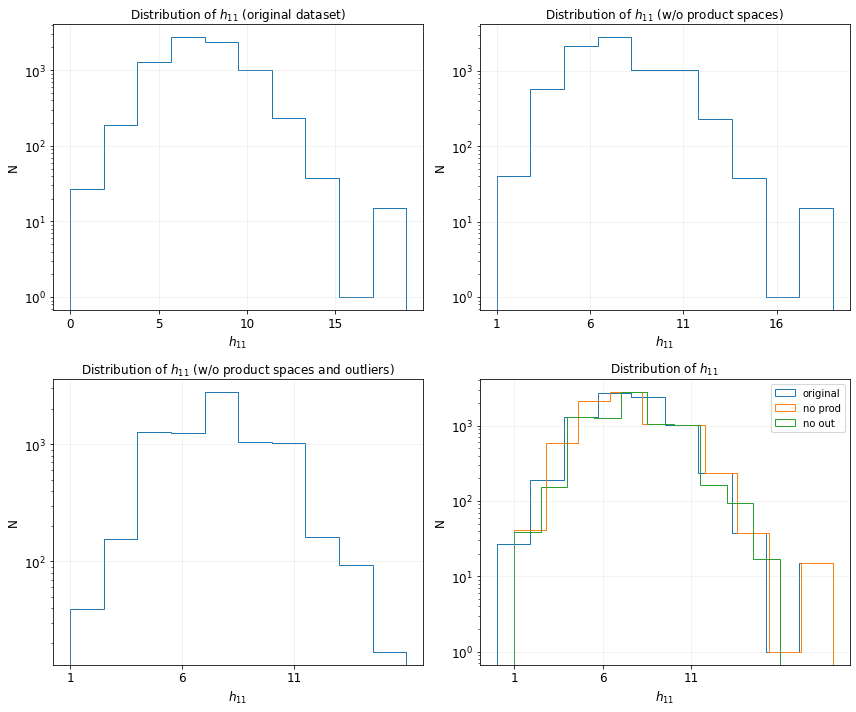

In [13]:
xplots  = 2
yplots  = 2
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

count_plot(ax[0,0], df['h11'],              title='Distribution of $h_{11}$ (original dataset)',                xlabel='$h_{11}$', ylog=True)
count_plot(ax[0,1], df_noprod['h11'],       title='Distribution of $h_{11}$ (w/o product spaces)',              xlabel='$h_{11}$', ylog=True)
count_plot(ax[1,0], df_noprod_noout['h11'], title='Distribution of $h_{11}$ (w/o product spaces and outliers)', xlabel='$h_{11}$', ylog=True)

count_plot(ax[1,1], df['h11'],              title='Distribution of $h_{11}$', xlabel='$h_{11}$', ylog=True, legend='original')
count_plot(ax[1,1], df_noprod['h11'],       title='Distribution of $h_{11}$', xlabel='$h_{11}$', ylog=True, legend='no prod')
count_plot(ax[1,1], df_noprod_noout['h11'], title='Distribution of $h_{11}$', xlabel='$h_{11}$', ylog=True, legend='no out')

save_fig('h11_distribution', logger=logger)
plt.show()
plt.close(fig)

And the distributions for $h_{21}$:

2020-04-01 17:28:27,344 --> INFO: Saving ./img/original/h21_distribution.png...
2020-04-01 17:28:28,058 --> INFO: Saved ./img/original/h21_distribution.png!


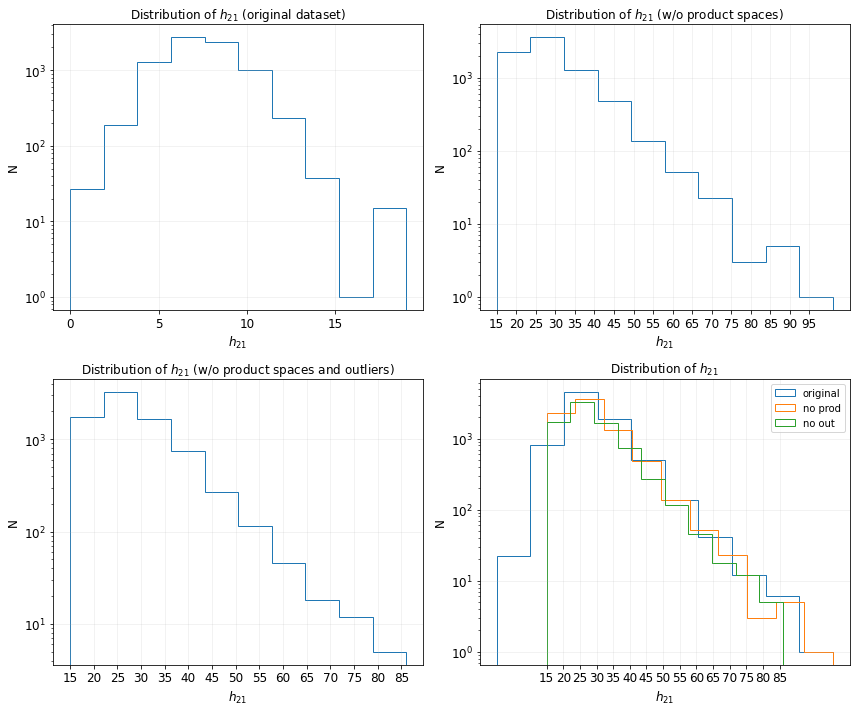

In [14]:
xplots  = 2
yplots  = 2
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

count_plot(ax[0,0], df['h11'],              title='Distribution of $h_{21}$ (original dataset)',                xlabel='$h_{21}$', ylog=True)
count_plot(ax[0,1], df_noprod['h21'],       title='Distribution of $h_{21}$ (w/o product spaces)',              xlabel='$h_{21}$', ylog=True)
count_plot(ax[1,0], df_noprod_noout['h21'], title='Distribution of $h_{21}$ (w/o product spaces and outliers)', xlabel='$h_{21}$', ylog=True)

count_plot(ax[1,1], df['h21'],              title='Distribution of $h_{21}$', xlabel='$h_{21}$', ylog=True, legend='original')
count_plot(ax[1,1], df_noprod['h21'],       title='Distribution of $h_{21}$', xlabel='$h_{21}$', ylog=True, legend='no prod')
count_plot(ax[1,1], df_noprod_noout['h21'], title='Distribution of $h_{21}$', xlabel='$h_{21}$', ylog=True, legend='no out')

save_fig('h21_distribution', logger=logger)
plt.show()
plt.close(fig)

### Distribution of the Labels

Now consider a few scalar features and show the distribution of the labels.

2020-04-01 17:28:29,967 --> INFO: Saving ./img/original/h11_h21_distribution.png...
2020-04-01 17:28:30,947 --> INFO: Saved ./img/original/h11_h21_distribution.png!


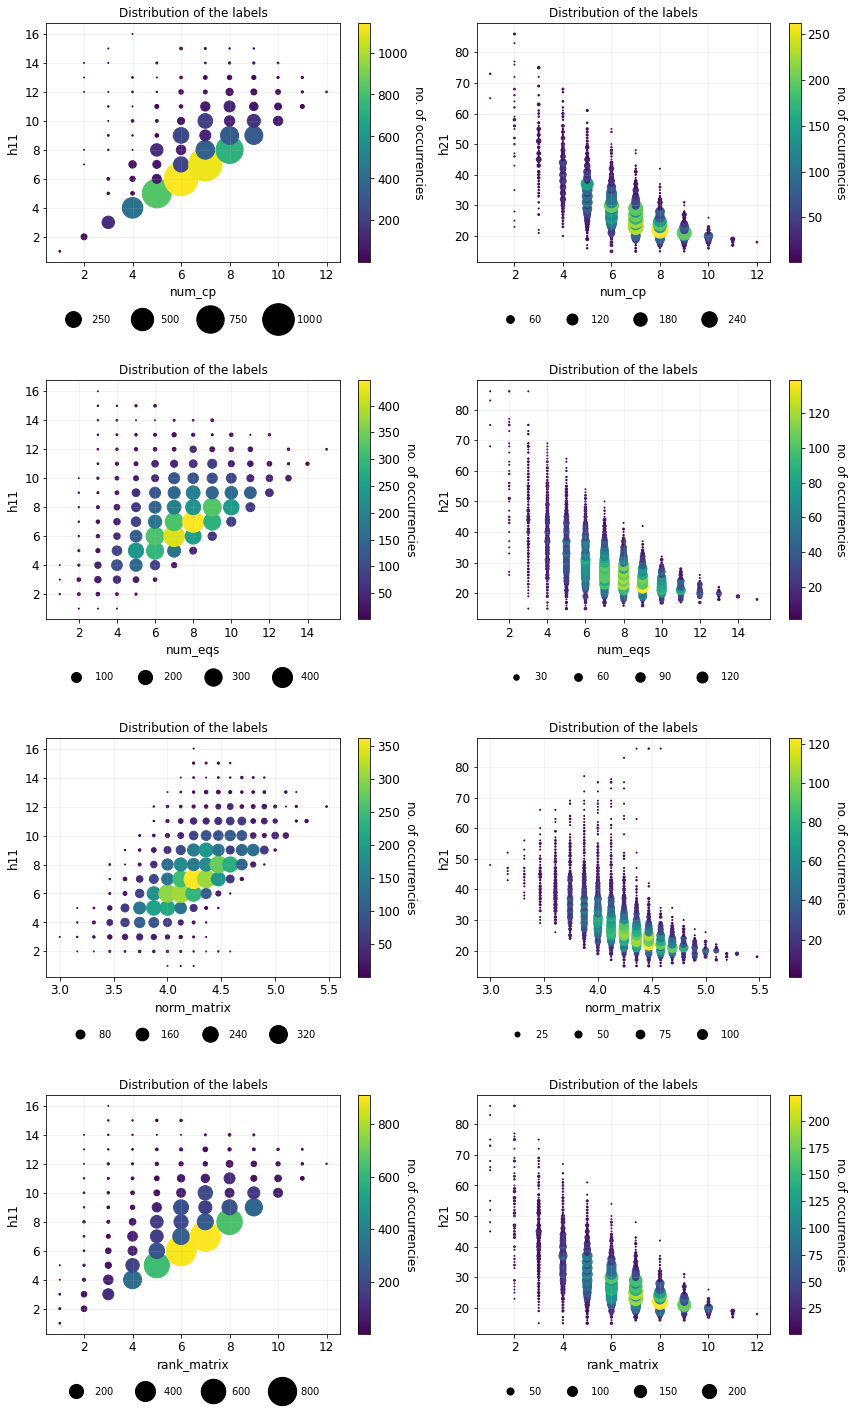

In [15]:
scat_features = [ 'num_cp', 'num_eqs', 'norm_matrix', 'rank_matrix' ]
scat_labels   = [ 'h11', 'h21' ]

fig, ax = plt.subplots(len(scat_features), len(scat_labels), figsize=(len(scat_labels)*mpl_width, len(scat_features)*mpl_height))
fig.tight_layout()

for n in range(len(scat_features)):
    for m in range(len(scat_labels)):
        scatter_plot(ax[n,m], np.array(list(get_counts(df_noprod_noout, scat_labels[m], scat_features[n]))).T,
                     title='Distribution of the labels', xlabel=scat_features[n], ylabel=scat_labels[m],
                     colour_label='no. of occurrencies', size_leg=5)
        
save_fig('h11_h21_distribution', logger=logger)
plt.show()
plt.close(fig)

## Data Extraction and Unsupervised Preprocessing

We then extract usable data and start to analyse the features through unsupervised preprocessing of the data.

In [16]:
# use only the dataframe without product spaces and outliers (and remove irrelevant features)
df = df_noprod_noout.drop(labels=df_noprod_noout.filter(regex='min|max|mean|media|c2|redun|size|euler|favour'), axis=1)

# divide features and labels
labels  = ['h11', 'h21']
logprint('Selecting labels...', logger=logger)
df_labs = df[labels]
logprint('Labels selected!', logger=logger)
df_feat = df.drop(labels=labels, axis=1)

# the only tensor feature
tensor_feat = ['matrix']

# then extract the others
logprint('Selecting features...', logger=logger)
scalar_feat = list(df_feat.select_dtypes(include=[np.int8, np.int16, np.int64, np.float16, np.float32, np.float64, np.float128]).columns)
vector_feat = list(df_feat.drop(labels=tensor_feat, axis=1).select_dtypes(include=['object']).columns)
logprint('Features selected!', logger=logger)

2020-04-01 17:28:32,184 --> INFO: Selecting labels...
2020-04-01 17:28:32,186 --> INFO: Labels selected!
2020-04-01 17:28:32,190 --> INFO: Selecting features...
2020-04-01 17:28:32,207 --> INFO: Features selected!


We then proceed to extract the features using the `ExtractTensor` transformer:

In [17]:
for feature in vector_feat:
    logprint('Extracting {} from vector features...'.format(feature), logger=logger)
    df_feat[feature] = ExtractTensor(flatten=False).fit_transform(df_feat[feature]) # do not flatten the output
logprint('Vector features have been extracted!', logger=logger)

for feature in tensor_feat:
    logprint('Extracting {} from tensor features...'.format(feature), logger=logger)
    df_feat[feature] = ExtractTensor(flatten=False).fit_transform(df_feat[feature]) # do not flatten the output
logprint('Tensor features have been extracted!', logger=logger)

df_feat = df_feat[scalar_feat + vector_feat + tensor_feat]
logprint('Features have been fully extracted!', logger=logger)

2020-04-01 17:28:32,220 --> INFO: Extracting dim_cp from vector features...
2020-04-01 17:28:32,680 --> INFO: Extracting num_dim_cp from vector features...
2020-04-01 17:28:32,977 --> INFO: Extracting deg_eqs from vector features...
2020-04-01 17:28:33,382 --> INFO: Extracting num_deg_eqs from vector features...
2020-04-01 17:28:33,686 --> INFO: Extracting dim_h0_amb from vector features...
2020-04-01 17:28:33,938 --> INFO: Vector features have been extracted!
2020-04-01 17:28:33,939 --> INFO: Extracting matrix from tensor features...
2020-04-01 17:28:34,843 --> INFO: Tensor features have been extracted!
2020-04-01 17:28:34,847 --> INFO: Features have been fully extracted!


We then show the correlation matrix between the scalar features in order to better understand the relation between features:

2020-04-01 17:28:35,461 --> INFO: Saving ./img/original/correlation_matrix.png...
2020-04-01 17:28:35,900 --> INFO: Saved ./img/original/correlation_matrix.png!


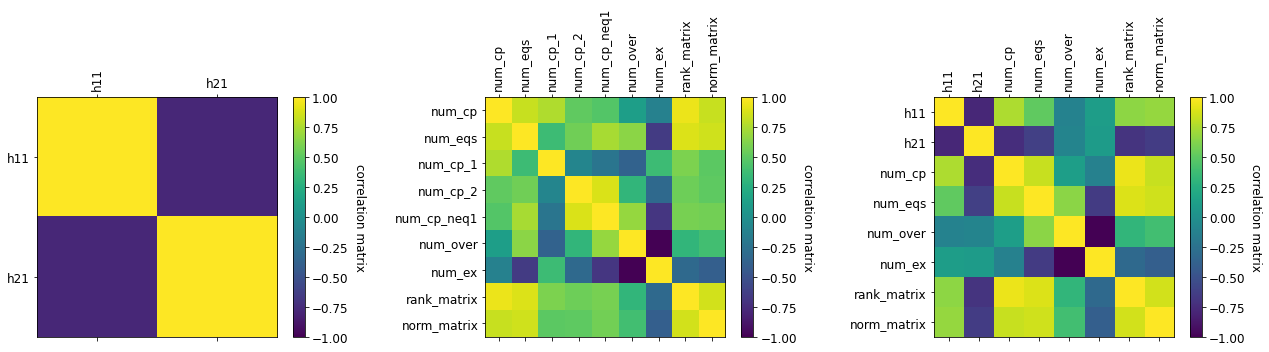

In [18]:
xplots  = 3
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

mat_plot(ax[0], df_labs.corr(), df_labs.columns.to_list())
mat_plot(ax[1], df_feat[scalar_feat].corr(), df_feat[scalar_feat].columns.to_list())
mat_plot(ax[2],
         df_labs.join(df_feat)[['h11', 'h21', 'num_cp', 'num_eqs', 'num_over', 'num_ex', 'rank_matrix', 'norm_matrix']].corr(),
         df_labs.join(df_feat)[['h11', 'h21', 'num_cp', 'num_eqs', 'num_over', 'num_ex', 'rank_matrix', 'norm_matrix']].columns.to_list()
        )

save_fig('correlation_matrix', logger=logger)
plt.show()
plt.close(fig)

### Nearest Neighbours Clustering

We consider the `KMeans` clustering of the component of the configuration matrix to probe the distribution of its components.

In [19]:
from sklearn.cluster import KMeans

# flatten the matrix
flat_matrix       = ExtractTensor(flatten=True).fit_transform(df_feat['matrix'])
flat_matrix_shape = np.shape(flat_matrix)

# create an empty array to store the labels
cluster_range = range(2,20)
kmeans_labels = np.empty((flat_matrix_shape[0], cluster_range.stop - cluster_range.start), dtype=np.int8)

# compute various clustering classifications
for n_clusters in cluster_range:
    logprint('Computing clustering for {:d} clusters...'.format(n_clusters), logger=logger)
    kmeans = KMeans(n_clusters=n_clusters, random_state=RAND, n_jobs=-1)
    kmeans.fit_transform(flat_matrix)
    kmeans_labels[:,n_clusters - cluster_range.start] = kmeans.labels_
logprint('Clustering task ended!', logger=logger)

2020-04-01 17:28:36,957 --> INFO: Computing clustering for 2 clusters...
2020-04-01 17:28:38,396 --> INFO: Computing clustering for 3 clusters...
2020-04-01 17:28:38,968 --> INFO: Computing clustering for 4 clusters...
2020-04-01 17:28:39,704 --> INFO: Computing clustering for 5 clusters...
2020-04-01 17:28:40,430 --> INFO: Computing clustering for 6 clusters...
2020-04-01 17:28:41,251 --> INFO: Computing clustering for 7 clusters...
2020-04-01 17:28:42,300 --> INFO: Computing clustering for 8 clusters...
2020-04-01 17:28:43,254 --> INFO: Computing clustering for 9 clusters...
2020-04-01 17:28:44,370 --> INFO: Computing clustering for 10 clusters...
2020-04-01 17:28:45,722 --> INFO: Computing clustering for 11 clusters...
2020-04-01 17:28:47,023 --> INFO: Computing clustering for 12 clusters...
2020-04-01 17:28:48,383 --> INFO: Computing clustering for 13 clusters...
2020-04-01 17:28:49,703 --> INFO: Computing clustering for 14 clusters...
2020-04-01 17:28:51,131 --> INFO: Computing cl

We then include this into the dataframe:

In [20]:
# add clustering to dataframe
df_feat['clustering'] = list(kmeans_labels)
logprint('Adding clustering labels to dataframe...', logger=logger)

# reorder the dataframe
df_feat = df_feat[scalar_feat + ['clustering'] + vector_feat + tensor_feat]
logprint('Labels have been added!', logger=logger)

2020-04-01 17:29:00,862 --> INFO: Adding clustering labels to dataframe...
2020-04-01 17:29:00,871 --> INFO: Labels have been added!


### Principal Components Analysis

We then proceed with the `PCA` on the configuration matrix. We compute the algorithms with 2 principal components only for plotting purposes but we will the discard the results. Instead we will keep the 99% variance PCA.

2020-04-01 17:29:00,888 --> INFO: Computing PCA with 2 components...
2020-04-01 17:29:01,144 --> INFO: PCA with 2 components computed!
2020-04-01 17:29:01,152 --> INFO: Ratio of the variance retained for each component: 9.09%, 5.59%
2020-04-01 17:29:01,466 --> INFO: Saving ./img/original/h11_h21_pca_2_comp.png...
2020-04-01 17:29:02,091 --> INFO: Saved ./img/original/h11_h21_pca_2_comp.png!


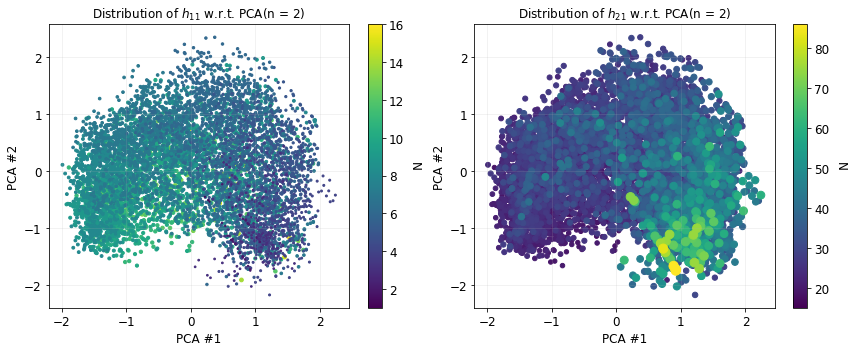

In [21]:
from sklearn.decomposition import PCA

# compute the PCA
logprint('Computing PCA with 2 components...', logger=logger)
pca_2 = PCA(n_components=2, random_state=RAND)
matrix_pca_2 = pca_2.fit_transform(flat_matrix)
logprint('PCA with 2 components computed!', logger=logger)
logprint('Ratio of the variance retained for each component: {:.2f}%, {:.2f}%'.format(pca_2.explained_variance_ratio_[0]*100, pca_2.explained_variance_ratio_[1]*100), logger=logger)

# plot the labels with respect to the principal components
xplots  = 2
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

scatter_plot(ax[0], [matrix_pca_2[:,0], matrix_pca_2[:,1], df_labs['h11']], title='Distribution of $h_{11}$ w.r.t. PCA(n = 2)', xlabel='PCA #1', ylabel='PCA #2', size=True)
scatter_plot(ax[1], [matrix_pca_2[:,0], matrix_pca_2[:,1], df_labs['h21']], title='Distribution of $h_{21}$ w.r.t. PCA(n = 2)', xlabel='PCA #1', ylabel='PCA #2', size=True)

save_fig('h11_h21_pca_2_comp', logger=logger)
plt.show()
plt.close(fig)

Then compute the "good" `PCA`:

In [22]:
# compute the PCA with 99% variance
logprint('Computing PCA with 99% variance...', logger=logger)
matrix_pca99 = PCA(n_components=0.99, random_state=42).fit_transform(flat_matrix)
logprint('PCA with 99% variance computed!', logger=logger)

# analyse the result
matrix_pca99_shape = matrix_pca99.shape
logprint('No. of components of the PCA: {:d}'.format(matrix_pca99_shape[1]), logger=logger)

# save the results inside the dataframe
df_feat['matrix_pca99'] = list(matrix_pca99)
logprint('Adding PCA to dataframe...', logger=logger)

# reorder the dataframe
df_feat = df_feat[scalar_feat + ['clustering'] + vector_feat + tensor_feat + ['matrix_pca99']]
logprint('PCA has been added!', logger=logger)

2020-04-01 17:29:02,917 --> INFO: Computing PCA with 99% variance...
2020-04-01 17:29:03,274 --> INFO: PCA with 99% variance computed!
2020-04-01 17:29:03,275 --> INFO: No. of components of the PCA: 81
2020-04-01 17:29:03,279 --> INFO: Adding PCA to dataframe...
2020-04-01 17:29:03,290 --> INFO: PCA has been added!


## Variable Ranking and Feature Selection

Using the engineered features including `PCA` and `KMeans`, we then train a [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) in order to extract the variables ranking for the dataset.

In [23]:
# create a vector of shapes inside the dataframe in order to be able to extract the features
features_shapes = {}

# scalars
for feature in scalar_feat:
    features_shapes[feature] = 1

# clustering
features_shapes['clustering'] = df_feat['clustering'].apply(np.shape).unique()[0][0] # unique() returns an array, thus we need to take only one element (the first)

rnd_for_features = np.c_[df_feat[scalar_feat].values,
                         ExtractTensor(flatten=True).fit_transform(df_feat['clustering']),
                        ] # create features input

# vectors
for feature in vector_feat:
    features_shapes[feature] = df_feat[feature].apply(np.shape).unique()[0][0]
    rnd_for_features = np.c_[rnd_for_features, ExtractTensor(flatten=True).fit_transform(df_feat[feature])]

# tensors
for feature in tensor_feat:
    features_shapes[feature] = df_feat[feature].apply(np.shape).unique()[0][0] * df_feat[feature].apply(np.shape).unique()[0][1]
    rnd_for_features = np.c_[rnd_for_features, ExtractTensor(flatten=True).fit_transform(df_feat[feature])]

# pca   
features_shapes['matrix_pca99'] = df_feat['matrix_pca99'].apply(np.shape).unique()[0][0]
rnd_for_features = np.c_[rnd_for_features, ExtractTensor(flatten=True).fit_transform(df_feat['matrix_pca99'])]

We then proceed with the decision trees:

In [24]:
from sklearn.ensemble import RandomForestRegressor

rnd_for_param = {'criterion': 'mse',
                 'n_estimators': 48,
                 'n_jobs':       -1,
                 'random_state': RAND
                }

logprint('Computing random forest for h11...', logger=logger)
rnd_for_h11 = RandomForestRegressor(**rnd_for_param)
rnd_for_h11.fit(rnd_for_features, df_labs['h11'])
logprint('Random forest for h11 completed!', logger=logger)
logprint('Accuracy of the random forest for h11: {:.3f}%'.format(accuracy_score(df_labs['h11'].values, rnd_for_h11.predict(rnd_for_features), rounding=np.floor)*100), logger=logger)

logprint('Computing random forest for h21...', logger=logger)
rnd_for_h21 = RandomForestRegressor(**rnd_for_param)
rnd_for_h21.fit(rnd_for_features, df_labs['h21'])
logprint('Random forest for h21 completed!', logger=logger)
logprint('Accuracy of the random forest for h21: {:.3f}%'.format(accuracy_score(df_labs['h21'].values, rnd_for_h21.predict(rnd_for_features), rounding=np.floor)*100), logger=logger)

2020-04-01 17:29:06,289 --> INFO: Computing random forest for h11...
2020-04-01 17:29:14,664 --> INFO: Random forest for h11 completed!
2020-04-01 17:29:14,796 --> INFO: Accuracy of the random forest for h11: 72.309%
2020-04-01 17:29:14,797 --> INFO: Computing random forest for h21...
2020-04-01 17:29:22,038 --> INFO: Random forest for h21 completed!
2020-04-01 17:29:22,178 --> INFO: Accuracy of the random forest for h21: 41.307%


We then consider the features importance and plot them for comparison:

In [25]:
# create a list with all the components
extended_features = []
for feature in features_shapes:
    extended_features.append(feature)
    for _ in range(features_shapes[feature] - 1):
        extended_features.append('')
        
# list of feature importances
feat_imp_h11 = list(zip(extended_features, rnd_for_h11.feature_importances_))
feat_imp_h21 = list(zip(extended_features, rnd_for_h21.feature_importances_))

Consider the scalar features first:

2020-04-01 17:29:22,625 --> INFO: Saving ./img/original/feat_imp_scalars.png...
2020-04-01 17:29:22,783 --> INFO: Saved ./img/original/feat_imp_scalars.png!


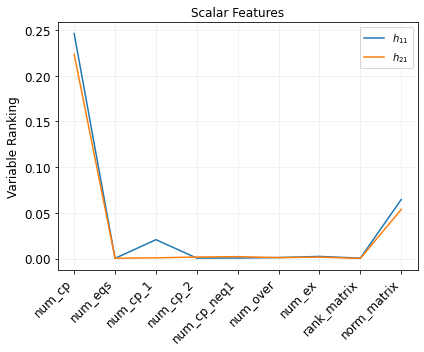

In [26]:
xplots  = 1
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

label_plot(ax, feat_imp_h11[0:np.sum([features_shapes[feature] for feature in scalar_feat])], title='Scalar Features', ylabel='Variable Ranking', legend='$h_{11}$')
label_plot(ax, feat_imp_h21[0:np.sum([features_shapes[feature] for feature in scalar_feat])], title='Scalar Features', ylabel='Variable Ranking', legend='$h_{21}$')

save_fig('feat_imp_scalars', logger=logger)
plt.show()
plt.close(fig)

Then consider vector features and clustering:

2020-04-01 17:29:23,250 --> INFO: Saving ./img/original/feat_imp_vectors_clustering.png...
2020-04-01 17:29:23,498 --> INFO: Saved ./img/original/feat_imp_vectors_clustering.png!


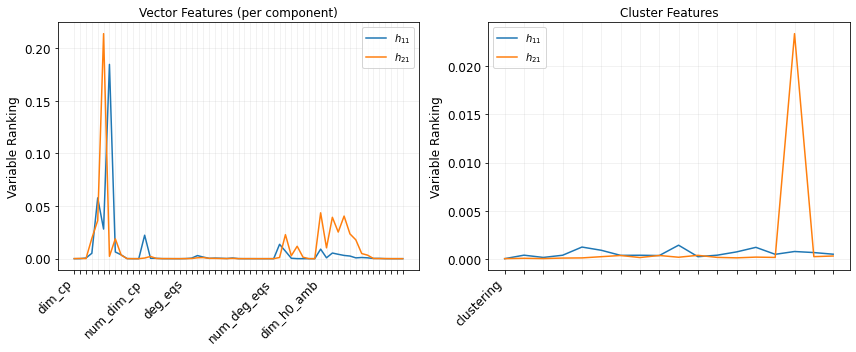

In [27]:
xplots  = 2
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

label_plot(ax[0], feat_imp_h11[np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']
                               :np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']
                               +np.sum([features_shapes[feature] for feature in vector_feat])], title='Vector Features (per component)', ylabel='Variable Ranking', legend='$h_{11}$')
label_plot(ax[0], feat_imp_h21[np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']
                               :np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']
                               +np.sum([features_shapes[feature] for feature in vector_feat])], title='Vector Features (per component)', ylabel='Variable Ranking', legend='$h_{21}$')

label_plot(ax[1], feat_imp_h11[np.sum([features_shapes[feature] for feature in scalar_feat])
                               :np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']], title='Cluster Features', ylabel='Variable Ranking', legend='$h_{11}$')
label_plot(ax[1], feat_imp_h21[np.sum([features_shapes[feature] for feature in scalar_feat])
                               :np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']], title='Cluster Features', ylabel='Variable Ranking', legend='$h_{21}$')

save_fig('feat_imp_vectors_clustering', logger=logger)
plt.show()
plt.close(fig)

Then consider the matrix and `PCA`:

2020-04-01 17:29:24,314 --> INFO: Saving ./img/original/feat_imp_matrix_pca.png...
2020-04-01 17:29:24,500 --> INFO: Saved ./img/original/feat_imp_matrix_pca.png!


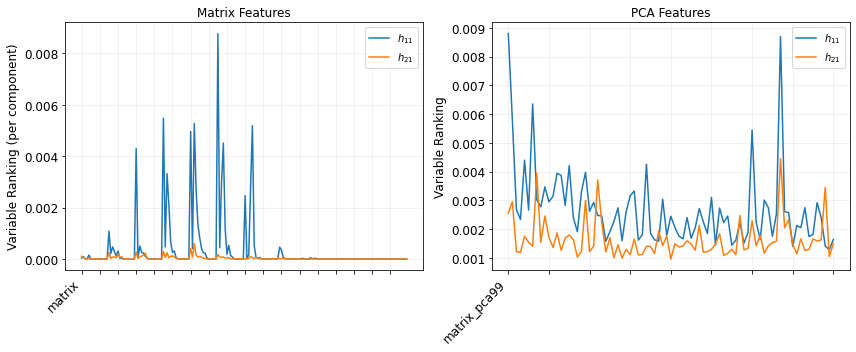

In [28]:
xplots  = 2
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

label_plot(ax[0], feat_imp_h11[np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']
                               +np.sum([features_shapes[feature] for feature in vector_feat])
                               :np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']
                               +np.sum([features_shapes[feature] for feature in vector_feat])
                               +features_shapes['matrix']], title='Matrix Features', ylabel='Variable Ranking (per component)', legend='$h_{11}$', binstep=10)
label_plot(ax[0], feat_imp_h21[np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']
                               +np.sum([features_shapes[feature] for feature in vector_feat])
                               :np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']
                               +np.sum([features_shapes[feature] for feature in vector_feat])
                               +features_shapes['matrix']], title='Matrix Features', ylabel='Variable Ranking (per component)', legend='$h_{21}$', binstep=10)

label_plot(ax[1], feat_imp_h11[np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']
                               +np.sum([features_shapes[feature] for feature in vector_feat])
                               +features_shapes['matrix']
                               :], title='PCA Features', ylabel='Variable Ranking', legend='$h_{11}$', binstep=10)
label_plot(ax[1], feat_imp_h21[np.sum([features_shapes[feature] for feature in scalar_feat])
                               +features_shapes['clustering']
                               +np.sum([features_shapes[feature] for feature in vector_feat])
                               +features_shapes['matrix']
                               :], title='PCA Features', ylabel='Variable Ranking', legend='$h_{21}$', binstep=10)

save_fig('feat_imp_matrix_pca', logger=logger)
plt.show()
plt.close(fig)

For comparison, we can plot the separate sum of each vector and tensor feature:

2020-04-01 17:29:24,931 --> INFO: Saving ./img/original/feat_imp_vector_tensor_sum.png...
2020-04-01 17:29:25,069 --> INFO: Saved ./img/original/feat_imp_vector_tensor_sum.png!


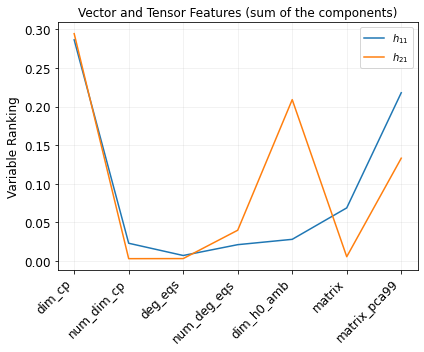

In [29]:
# sum of the scalars
scalar_h11_sum = np.sum([f[1] for f in feat_imp_h11[0:np.sum([features_shapes[feature] for feature in scalar_feat])]])
scalar_h21_sum = np.sum([f[1] for f in feat_imp_h21[0:np.sum([features_shapes[feature] for feature in scalar_feat])]])

# sum of dim_cp importances
dim_cp_h11_sum = np.sum([f[1] for f in feat_imp_h11[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                           +features_shapes['clustering']
                                                           :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                           +features_shapes['clustering']
                                                           +features_shapes['dim_cp']]])
dim_cp_h21_sum = np.sum([f[1] for f in feat_imp_h21[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                           +features_shapes['clustering']
                                                           :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                           +features_shapes['clustering']
                                                           +features_shapes['dim_cp']]])

# sum of num_dim_cp importances
num_dim_cp_h11_sum = np.sum([f[1] for f in feat_imp_h11[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                               +features_shapes['clustering']
                                                               +features_shapes['dim_cp']
                                                               :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                               +features_shapes['clustering']
                                                               +features_shapes['dim_cp']
                                                               +features_shapes['num_dim_cp']]])
num_dim_cp_h21_sum = np.sum([f[1] for f in feat_imp_h21[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                               +features_shapes['clustering']
                                                               +features_shapes['dim_cp']
                                                               :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                               +features_shapes['clustering']
                                                               +features_shapes['dim_cp']
                                                               +features_shapes['num_dim_cp']]])

# sum of deg_eqs importances
deg_eqs_h11_sum = np.sum([f[1] for f in feat_imp_h11[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                            +features_shapes['clustering']
                                                            +features_shapes['dim_cp']
                                                            +features_shapes['num_dim_cp']
                                                            :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                            +features_shapes['clustering']
                                                            +features_shapes['dim_cp']
                                                            +features_shapes['num_dim_cp']
                                                            +features_shapes['deg_eqs']]])
deg_eqs_h21_sum = np.sum([f[1] for f in feat_imp_h21[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                            +features_shapes['clustering']
                                                            +features_shapes['dim_cp']
                                                            +features_shapes['num_dim_cp']
                                                            :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                            +features_shapes['clustering']
                                                            +features_shapes['dim_cp']
                                                            +features_shapes['num_dim_cp']
                                                            +features_shapes['deg_eqs']]])

# sum of num_deg_eqs importances
num_deg_eqs_h11_sum = np.sum([f[1] for f in feat_imp_h11[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                                +features_shapes['clustering']
                                                                +features_shapes['dim_cp']
                                                                +features_shapes['num_dim_cp']
                                                                +features_shapes['deg_eqs']
                                                                :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                                +features_shapes['clustering']
                                                                +features_shapes['dim_cp']
                                                                +features_shapes['num_dim_cp']
                                                                +features_shapes['deg_eqs']
                                                                +features_shapes['num_deg_eqs']]])
num_deg_eqs_h21_sum = np.sum([f[1] for f in feat_imp_h21[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                                +features_shapes['clustering']
                                                                +features_shapes['dim_cp']
                                                                +features_shapes['num_dim_cp']
                                                                +features_shapes['deg_eqs']
                                                                :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                                +features_shapes['clustering']
                                                                +features_shapes['dim_cp']
                                                                +features_shapes['num_dim_cp']
                                                                +features_shapes['deg_eqs']
                                                                +features_shapes['num_deg_eqs']]])

# sum of dim_h0_amb importances
dim_h0_amb_h11_sum = np.sum([f[1] for f in feat_imp_h11[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                               +features_shapes['clustering']
                                                               +features_shapes['dim_cp']
                                                               +features_shapes['num_dim_cp']
                                                               +features_shapes['deg_eqs']
                                                               +features_shapes['num_deg_eqs']
                                                               :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                               +features_shapes['clustering']
                                                               +features_shapes['dim_cp']
                                                               +features_shapes['num_dim_cp']
                                                               +features_shapes['deg_eqs']
                                                               +features_shapes['num_deg_eqs']
                                                               +features_shapes['dim_h0_amb']]])
dim_h0_amb_h21_sum = np.sum([f[1] for f in feat_imp_h21[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                               +features_shapes['clustering']
                                                               +features_shapes['dim_cp']
                                                               +features_shapes['num_dim_cp']
                                                               +features_shapes['deg_eqs']
                                                               +features_shapes['num_deg_eqs']
                                                               :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                               +features_shapes['clustering']
                                                               +features_shapes['dim_cp']
                                                               +features_shapes['num_dim_cp']
                                                               +features_shapes['deg_eqs']
                                                               +features_shapes['num_deg_eqs']
                                                               +features_shapes['dim_h0_amb']]])

# sum of the vector importances
vector_h11_sum = dim_cp_h11_sum + num_dim_cp_h11_sum + deg_eqs_h11_sum + num_deg_eqs_h11_sum + dim_h0_amb_h11_sum
vector_h21_sum = dim_cp_h21_sum + num_dim_cp_h21_sum + deg_eqs_h21_sum + num_deg_eqs_h21_sum + dim_h0_amb_h21_sum

# sum of the importance of the matrix components
matrix_h11_sum = np.sum([f[1] for f in feat_imp_h11[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                           +features_shapes['clustering']
                                                           +np.sum([features_shapes[feature] for feature in vector_feat])
                                                           :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                           +features_shapes['clustering']
                                                           +np.sum([features_shapes[feature] for feature in vector_feat])
                                                           +features_shapes['matrix']]])
matrix_h21_sum = np.sum([f[1] for f in feat_imp_h21[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                           +features_shapes['clustering']
                                                           +np.sum([features_shapes[feature] for feature in vector_feat])
                                                           :np.sum([features_shapes[feature] for feature in scalar_feat])
                                                           +features_shapes['clustering']
                                                           +np.sum([features_shapes[feature] for feature in vector_feat])
                                                           +features_shapes['matrix']]])

# sum of the importance of the PCA components
pca_h11_sum = np.sum([f[1] for f in feat_imp_h11[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                        +features_shapes['clustering']
                                                        +np.sum([features_shapes[feature] for feature in vector_feat])
                                                        +features_shapes['matrix']
                                                        :]])
pca_h21_sum = np.sum([f[1] for f in feat_imp_h21[np.sum([features_shapes[feature] for feature in scalar_feat])
                                                        +features_shapes['clustering']
                                                        +np.sum([features_shapes[feature] for feature in vector_feat])
                                                        +features_shapes['matrix']
                                                        :]])

# plot the sum of vector and tensor features
xplots  = 1
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

label_plot(ax,
           [('dim_cp',       dim_cp_h11_sum),
            ('num_dim_cp',   num_dim_cp_h11_sum),
            ('deg_eqs',      deg_eqs_h11_sum),
            ('num_deg_eqs',  num_deg_eqs_h11_sum),
            ('dim_h0_amb',   dim_h0_amb_h11_sum),
            ('matrix',       matrix_h11_sum),
            ('matrix_pca99', pca_h11_sum)
           ],
           title='Vector and Tensor Features (sum of the components)',
           ylabel='Variable Ranking',
           legend='$h_{11}$'
          )
label_plot(ax,
           [('dim_cp',       dim_cp_h21_sum),
            ('num_dim_cp',   num_dim_cp_h21_sum),
            ('deg_eqs',      deg_eqs_h21_sum),
            ('num_deg_eqs',  num_deg_eqs_h21_sum),
            ('dim_h0_amb',   dim_h0_amb_h21_sum),
            ('matrix',       matrix_h21_sum),
            ('matrix_pca99', pca_h21_sum)
           ],
           title='Vector and Tensor Features (sum of the components)',
           ylabel='Variable Ranking',
           legend='$h_{21}$'
          )

save_fig('feat_imp_vector_tensor_sum', logger=logger)
plt.show()
plt.close(fig)

For better visualisation, we can also plot the sum of scalar, vector and tensor features:

2020-04-01 17:29:25,358 --> INFO: Saving ./img/original/feat_imp_sum.png...
2020-04-01 17:29:25,488 --> INFO: Saved ./img/original/feat_imp_sum.png!


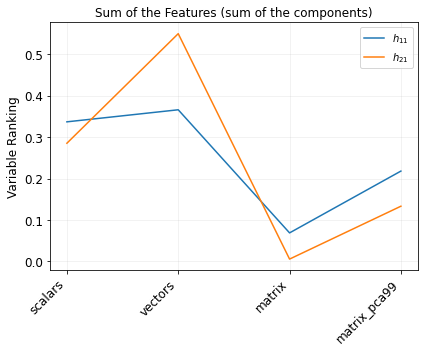

In [30]:
# plot the sum of vector and tensor features
xplots  = 1
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

label_plot(ax,
           [('scalars',      scalar_h11_sum),
            ('vectors',      vector_h11_sum),
            ('matrix',       matrix_h11_sum),
            ('matrix_pca99', pca_h11_sum)
           ],
           title='Sum of the Features (sum of the components)',
           ylabel='Variable Ranking',
           legend='$h_{11}$'
          )
label_plot(ax,
           [('scalars',      scalar_h21_sum),
            ('vectors',      vector_h21_sum),
            ('matrix',       matrix_h21_sum),
            ('matrix_pca99', pca_h21_sum)
           ],
           title='Sum of the Features (sum of the components)',
           ylabel='Variable Ranking',
           legend='$h_{21}$'
          )

save_fig('feat_imp_sum', logger=logger)
plt.show()
plt.close(fig)

Given the previous results, in order to get more valuable results we keep in the engineered set only those variable which where able to reach at least the threshold of 5% in the feature importances. We therefore select:

- `num_cp`, `dim_cp`, `matrix_pca99` for $h_{11}$
- `num_cp`, `dim_cp`, `dim_h0_amb`, `matrix_pca99` for $h_{21}$

We will however keep a copy of the `matrix` (not flattened) to feed the neural networks later on.

In [31]:
# save the dataset to file
logprint('Saving engineered dataset to file...', logger=logger)
df_labs.join(df_feat[['num_cp', 'dim_cp', 'dim_h0_amb', 'matrix_pca99']]).to_hdf(path.join(ROOT_DIR, 'cicy3o_eng.h5.zip'), key='cicy3o_eng', complevel=9, complib='zlib')
logprint('Engineered dataset saved to file!', logger=logger)

logprint('Saving matrix to file...', logger=logger)
df_labs.join(df_feat['matrix']).to_hdf(path.join(ROOT_DIR, 'cicy3o_matrix.h5.zip'), key='cicy3o_matrix', complevel=9, complib='zlib')
logprint('Matrix saved to file!', logger=logger)

2020-04-01 17:29:25,630 --> INFO: Saving engineered dataset to file...
2020-04-01 17:29:25,829 --> INFO: Engineered dataset saved to file!
2020-04-01 17:29:25,830 --> INFO: Saving matrix to file...
2020-04-01 17:29:25,920 --> INFO: Matrix saved to file!


/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['dim_cp', 'dim_h0_amb', 'matrix_pca99'], dtype='object')]

  encoding=encoding,
/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['matrix'], dtype='object')]

  encoding=encoding,


## Machine Learning Analysis

We now apply several ML algorithms to the engineered dataset and try to get valuable predictions on the labels.

In [32]:
# reload the dataset
DF_ENG_PATH = path.join(ROOT_DIR, 'cicy3o_eng.h5.zip')
DF_MAT_PATH = path.join(ROOT_DIR, 'cicy3o_matrix.h5.zip')

# load featured engineered set
if path.isfile(DF_ENG_PATH):
    df = load_dataset(DF_ENG_PATH, logger=logger)
    
    # extract labels and features
    df_labs = df[['h11', 'h21']]
    df_feat = df.drop(labels=['h11', 'h21'], axis=1)
    
    # divide features according to training sets
    logprint('Extracting features from the engineered database...', logger=logger)
    num_cp       = ExtractTensor(flatten=True).fit_transform(df_feat['num_cp'])
    dim_cp       = ExtractTensor(flatten=True).fit_transform(df_feat['dim_cp'])
    features_h11 = np.c_[ExtractTensor(flatten=True).fit_transform(df_feat['num_cp']),
                         ExtractTensor(flatten=True).fit_transform(df_feat['dim_cp']),
                         ExtractTensor(flatten=True).fit_transform(df_feat['matrix_pca99'])
                        ]
    features_h21 = np.c_[ExtractTensor(flatten=True).fit_transform(df_feat['num_cp']),
                         ExtractTensor(flatten=True).fit_transform(df_feat['dim_cp']),
                         ExtractTensor(flatten=True).fit_transform(df_feat['dim_h0_amb']),
                         ExtractTensor(flatten=True).fit_transform(df_feat['matrix_pca99'])
                        ]
    logprint('Features extracted!', logger=logger)
else:
    logprint('File is not present: cannot read engineered database!', stream='error', logger=logger)

# load matrix
if path.isfile(DF_MAT_PATH):
    df = load_dataset(DF_MAT_PATH, logger=logger)
    
    # extract labels and features
    df_labs = df[['h11', 'h21']]
    df_feat = df.drop(labels=['h11', 'h21'], axis=1)
    
    # divide features according to training sets
    logprint('Extracting features from the matrix database...', logger=logger)
    matrix = ExtractTensor(flatten=True).fit_transform(df_feat['matrix'])
    logprint('Features extracted!', logger=logger)
else:
    logprint('File is not present: cannot read matrix database!', stream='error', logger=logger)

2020-04-01 17:29:25,935 --> INFO: Reading database...
2020-04-01 17:29:26,004 --> INFO: Database loaded!
2020-04-01 17:29:26,015 --> INFO: Extracting features from the engineered database...
2020-04-01 17:29:27,958 --> INFO: Features extracted!
2020-04-01 17:29:27,959 --> INFO: Reading database...
2020-04-01 17:29:28,010 --> INFO: Database loaded!
2020-04-01 17:29:28,024 --> INFO: Extracting features from the matrix database...
2020-04-01 17:29:28,556 --> INFO: Features extracted!


Then build a training and a test sets and define a cross-validation strategy.

In [33]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics         import make_scorer
from sklearn.model_selection import GridSearchCV
from skopt                   import BayesSearchCV
from skopt.space             import Categorical, Integer, Real

# split into training and test sets
features_h11_train, features_h11_test, \
features_h21_train, features_h21_test, \
num_cp_train, num_cp_test, \
dim_cp_train, dim_cp_test, \
matrix_train, matrix_test, \
h11_train, h11_test, \
h21_train, h21_test = train_test_split(features_h11,
                                       features_h21,
                                       num_cp,
                                       dim_cp,
                                       matrix,
                                       df_labs['h11'].values,
                                       df_labs['h21'].values,
                                       test_size=0.1,
                                       shuffle=True,
                                       random_state=RAND
                                      )
# cross-validation strategy
cv     = KFold(n_splits=9, shuffle=False)
scorer = lambda x: make_scorer(accuracy_score, greater_is_better=True, rounding=x)

# hyperparameter optimization iterations
n_iter = 50

At the end of each training we will then save the models trained on the feature engineered sets.

In [34]:
import joblib

# save the models
def save_model(filename, estimator):
    """Save trained models to file.
    
    Required arguments:
        filename:  the name of the file (w/o extension)
        estimator: the model to save
    """
    
    MOD_FILE = path.join(MOD_PATH, filename + '.joblib.xz')
    
    logprint('Saving the estimator to {}.joblib.xz...'.format(filename), logger=logger)
    joblib.dump(estimator, MOD_FILE, compress=('xz',9))
    logprint('Saved {}.joblib.xz!'.format(filename), logger=logger)

### Linear Regression

2020-04-01 17:29:28,607 --> INFO: Evaluating Linear Regression...
2020-04-01 17:29:28,608 --> INFO: Fitting the matrix baseline...
2020-04-01 17:29:37,581 --> INFO: Best parameters: {'fit_intercept': False, 'normalize': True}
2020-04-01 17:29:37,582 --> INFO: Accuracy (floor) of cross-validation: (50.771 ± 1.848)%
2020-04-01 17:29:37,603 --> INFO: Accuracy (floor) of the predictions: 50.636%
2020-04-01 17:29:46,299 --> INFO: Best parameters: {'fit_intercept': True, 'normalize': False}
2020-04-01 17:29:46,300 --> INFO: Accuracy (floor) of cross-validation: (10.814 ± 0.980)%
2020-04-01 17:29:46,325 --> INFO: Accuracy (floor) of the predictions: 12.341%
2020-04-01 17:29:46,327 --> INFO: Fitting the num_cp baseline...
2020-04-01 17:29:46,781 --> INFO: Best parameters: {'fit_intercept': True, 'normalize': True}
2020-04-01 17:29:46,782 --> INFO: Accuracy (floor) of cross-validation: (61.897 ± 1.006)%
2020-04-01 17:29:46,785 --> INFO: Accuracy (floor) of the predictions: 63.232%
2020-04-01 17

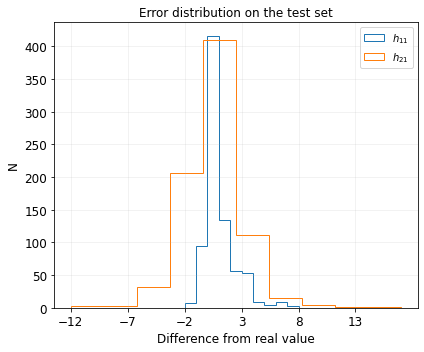

2020-04-01 17:30:05,451 --> INFO: Saving the estimator to lin_reg_h11.joblib.xz...
2020-04-01 17:30:05,482 --> INFO: Saved lin_reg_h11.joblib.xz!
2020-04-01 17:30:05,483 --> INFO: Saving the estimator to lin_reg_h21.joblib.xz...
2020-04-01 17:30:05,515 --> INFO: Saved lin_reg_h21.joblib.xz!


In [35]:
from sklearn.linear_model    import LinearRegression
logprint('Evaluating Linear Regression...', logger=logger)

search_params = {'fit_intercept': [ True, False ],
                 'normalize':     [ True, False ]
                }
rounding = np.floor

# compute matrix baseline
logprint('Fitting the matrix baseline...', logger=logger)
lin_reg_h11 = GridSearchCV(LinearRegression(), search_params, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_reg_h11.fit(matrix_train, h11_train)
gridcv_score(lin_reg_h11, rounding=rounding, logger=logger)
prediction_score(lin_reg_h11, matrix_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lin_reg_h21 = GridSearchCV(LinearRegression(), search_params, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_reg_h21.fit(matrix_train, h21_train)
gridcv_score(lin_reg_h21, rounding=rounding, logger=logger)
prediction_score(lin_reg_h21, matrix_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute num_cp baseline
logprint('Fitting the num_cp baseline...', logger=logger)
lin_reg_h11 = GridSearchCV(LinearRegression(), search_params, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_reg_h11.fit(np.reshape(num_cp_train, (-1,1)), h11_train)
gridcv_score(lin_reg_h11, rounding=rounding, logger=logger)
prediction_score(lin_reg_h11, np.reshape(num_cp_test, (-1,1)), h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lin_reg_h21 = GridSearchCV(LinearRegression(), search_params, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_reg_h21.fit(np.reshape(num_cp_train, (-1,1)), h21_train)
gridcv_score(lin_reg_h21, rounding=rounding, logger=logger)
prediction_score(lin_reg_h21, np.reshape(num_cp_test, (-1,1)), h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute dim_cp baseline
logprint('Fitting the dim_cp baseline...', logger=logger)
lin_reg_h11 = GridSearchCV(LinearRegression(), search_params, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_reg_h11.fit(dim_cp_train, h11_train)
gridcv_score(lin_reg_h11, rounding=rounding, logger=logger)
prediction_score(lin_reg_h11, dim_cp_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lin_reg_h21 = GridSearchCV(LinearRegression(), search_params, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_reg_h21.fit(dim_cp_train, h21_train)
gridcv_score(lin_reg_h21, rounding=rounding, logger=logger)
prediction_score(lin_reg_h21, dim_cp_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute feature engineered dataset
logprint('Fitting the feature engineered dataset...', logger=logger)
lin_reg_h11 = GridSearchCV(LinearRegression(), search_params, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_reg_h11.fit(features_h11_train, h11_train)
gridcv_score(lin_reg_h11, rounding=rounding, logger=logger)
prediction_score(lin_reg_h11, features_h11_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lin_reg_h21 = GridSearchCV(LinearRegression(), search_params, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_reg_h21.fit(features_h21_train, h21_train)
gridcv_score(lin_reg_h21, rounding=rounding, logger=logger)
prediction_score(lin_reg_h21, features_h21_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# plot the error difference of the feature engineered dataset
logprint('Plotting error distribution...', logger=logger)
xplots  = 1
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

count_plot(ax,
           error_diff(h11_test,
                      lin_reg_h11.best_estimator_.predict(features_h11_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{11}$')
count_plot(ax,
           error_diff(h21_test,
                      lin_reg_h21.best_estimator_.predict(features_h21_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{21}$')

save_fig('lin_reg_error_eng', logger=logger)
plt.show()
plt.close(fig)

# Saving the feature engineered models
save_model('lin_reg_h11', lin_reg_h11.best_estimator_)
save_model('lin_reg_h21', lin_reg_h21.best_estimator_)

### Lasso

2020-04-01 17:30:05,538 --> INFO: Evaluating Lasso...
2020-04-01 17:30:05,543 --> INFO: Fitting the matrix baseline...
2020-04-01 17:33:07,735 --> INFO: Best parameters: OrderedDict([('alpha', 2.7412765525230704e-05), ('fit_intercept', 0), ('normalize', 0), ('positive', 1)])
2020-04-01 17:33:07,736 --> INFO: Accuracy (floor) of cross-validation: (50.941 ± 1.780)%
2020-04-01 17:33:07,744 --> INFO: Accuracy (floor) of the predictions: 50.382%
2020-04-01 17:43:02,608 --> INFO: Best parameters: OrderedDict([('alpha', 6.905566574001633e-05), ('fit_intercept', 1), ('normalize', 1), ('positive', 0)])
2020-04-01 17:43:02,609 --> INFO: Accuracy (floor) of cross-validation: (11.309 ± 0.861)%
2020-04-01 17:43:02,626 --> INFO: Accuracy (floor) of the predictions: 12.850%
2020-04-01 17:43:02,627 --> INFO: Fitting the num_cp baseline...
2020-04-01 17:44:17,233 --> INFO: Best parameters: OrderedDict([('alpha', 5.00098125487702e-05), ('fit_intercept', 1), ('normalize', 1), ('positive', 0)])
2020-04-01

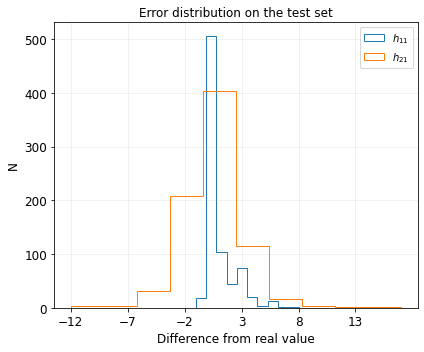

2020-04-01 17:58:20,342 --> INFO: Saving the estimator to lasso_h11.joblib.xz...
2020-04-01 17:58:20,391 --> INFO: Saved lasso_h11.joblib.xz!
2020-04-01 17:58:20,392 --> INFO: Saving the estimator to lasso_h21.joblib.xz...
2020-04-01 17:58:20,440 --> INFO: Saved lasso_h21.joblib.xz!


In [36]:
from sklearn.linear_model import Lasso
logprint('Evaluating Lasso...', logger=logger)

search_params = {'alpha':         Real(1e-6, 1e2, base=10, prior='log-uniform'),
                 'fit_intercept': Integer(False, True),
                 'normalize':     Integer(False, True),
                 'positive':      Integer(False, True)
                }
rounding = np.floor

# compute matrix baseline
logprint('Fitting the matrix baseline...', logger=logger)
lasso_h11 = BayesSearchCV(Lasso(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lasso_h11.fit(matrix_train, h11_train)
gridcv_score(lasso_h11, rounding=rounding, logger=logger)
prediction_score(lasso_h11, matrix_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lasso_h21 = BayesSearchCV(Lasso(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lasso_h21.fit(matrix_train, h21_train)
gridcv_score(lasso_h21, rounding=rounding, logger=logger)
prediction_score(lasso_h21, matrix_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute num_cp baseline
logprint('Fitting the num_cp baseline...', logger=logger)
lasso_h11 = BayesSearchCV(Lasso(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lasso_h11.fit(np.reshape(num_cp_train, (-1,1)), h11_train)
gridcv_score(lasso_h11, rounding=rounding, logger=logger)
prediction_score(lasso_h11, np.reshape(num_cp_test, (-1,1)), h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lasso_h21 = BayesSearchCV(Lasso(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lasso_h21.fit(np.reshape(num_cp_train, (-1,1)), h21_train)
gridcv_score(lasso_h21, rounding=rounding, logger=logger)
prediction_score(lasso_h21, np.reshape(num_cp_test, (-1,1)), h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute dim_cp baseline
logprint('Fitting the dim_cp baseline...', logger=logger)
lasso_h11 = BayesSearchCV(Lasso(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lasso_h11.fit(dim_cp_train, h11_train)
gridcv_score(lasso_h11, rounding=rounding, logger=logger)
prediction_score(lasso_h11, dim_cp_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lasso_h21 = BayesSearchCV(Lasso(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lasso_h21.fit(dim_cp_train, h21_train)
gridcv_score(lasso_h21, rounding=rounding, logger=logger)
prediction_score(lasso_h21, dim_cp_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute feature engineered dataset
logprint('Fitting the feature engineered dataset...', logger=logger)
lasso_h11 = BayesSearchCV(Lasso(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lasso_h11.fit(features_h11_train, h11_train)
gridcv_score(lasso_h11, rounding=rounding, logger=logger)
prediction_score(lasso_h11, features_h11_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lasso_h21 = BayesSearchCV(Lasso(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lasso_h21.fit(features_h21_train, h21_train)
gridcv_score(lasso_h21, rounding=rounding, logger=logger)
prediction_score(lasso_h21, features_h21_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# plot the error difference of the feature engineered dataset
logprint('Plotting error distribution...', logger=logger)
xplots  = 1
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

count_plot(ax,
           error_diff(h11_test,
                      lasso_h11.best_estimator_.predict(features_h11_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{11}$')
count_plot(ax,
           error_diff(h21_test,
                      lasso_h21.best_estimator_.predict(features_h21_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{21}$')

save_fig('lasso_error_eng', logger=logger)
plt.show()
plt.close(fig)

# Saving the feature engineered models
save_model('lasso_h11', lasso_h11.best_estimator_)
save_model('lasso_h21', lasso_h21.best_estimator_)

### Ridge

2020-04-01 17:58:20,476 --> INFO: Evaluating Ridge...
2020-04-01 17:58:20,480 --> INFO: Fitting the matrix baseline...
2020-04-01 18:00:49,954 --> INFO: Best parameters: OrderedDict([('alpha', 1.1740758611222808), ('fit_intercept', 0), ('normalize', 0)])
2020-04-01 18:00:49,955 --> INFO: Accuracy (floor) of cross-validation: (50.955 ± 1.834)%
2020-04-01 18:00:49,966 --> INFO: Accuracy (floor) of the predictions: 50.509%
2020-04-01 18:02:52,008 --> INFO: Best parameters: OrderedDict([('alpha', 0.017239932183891138), ('fit_intercept', 1), ('normalize', 1)])
2020-04-01 18:02:52,008 --> INFO: Accuracy (floor) of cross-validation: (11.380 ± 0.951)%
2020-04-01 18:02:52,025 --> INFO: Accuracy (floor) of the predictions: 10.433%
2020-04-01 18:02:52,028 --> INFO: Fitting the num_cp baseline...
2020-04-01 18:03:50,428 --> INFO: Best parameters: OrderedDict([('alpha', 100.0), ('fit_intercept', 1), ('normalize', 0)])
2020-04-01 18:03:50,428 --> INFO: Accuracy (floor) of cross-validation: (61.925 ±

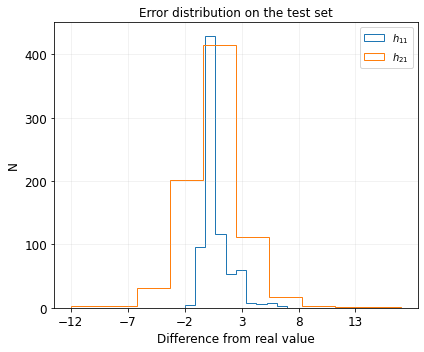

2020-04-01 18:09:59,482 --> INFO: Saving the estimator to ridge_h11.joblib.xz...
2020-04-01 18:09:59,514 --> INFO: Saved ridge_h11.joblib.xz!
2020-04-01 18:09:59,515 --> INFO: Saving the estimator to ridge_h21.joblib.xz...
2020-04-01 18:09:59,548 --> INFO: Saved ridge_h21.joblib.xz!


In [37]:
from sklearn.linear_model import Ridge
logprint('Evaluating Ridge...', logger=logger)

search_params = {'alpha':         Real(1e-6, 1e2, base=10, prior='log-uniform'),
                 'fit_intercept': Integer(False, True),
                 'normalize':     Integer(False, True)
                }
rounding = np.floor

# compute matrix baseline
logprint('Fitting the matrix baseline...', logger=logger)
ridge_h11 = BayesSearchCV(Ridge(tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
ridge_h11.fit(matrix_train, h11_train)
gridcv_score(ridge_h11, rounding=rounding, logger=logger)
prediction_score(ridge_h11, matrix_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

ridge_h21 = BayesSearchCV(Ridge(tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
ridge_h21.fit(matrix_train, h21_train)
gridcv_score(ridge_h21, rounding=rounding, logger=logger)
prediction_score(ridge_h21, matrix_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute num_cp baseline
logprint('Fitting the num_cp baseline...', logger=logger)
ridge_h11 = BayesSearchCV(Ridge(tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
ridge_h11.fit(np.reshape(num_cp_train, (-1,1)), h11_train)
gridcv_score(ridge_h11, rounding=rounding, logger=logger)
prediction_score(ridge_h11, np.reshape(num_cp_test, (-1,1)), h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

ridge_h21 = BayesSearchCV(Ridge(tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
ridge_h21.fit(np.reshape(num_cp_train, (-1,1)), h21_train)
gridcv_score(ridge_h21, rounding=rounding, logger=logger)
prediction_score(ridge_h21, np.reshape(num_cp_test, (-1,1)), h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute dim_cp baseline
logprint('Fitting the dim_cp baseline...', logger=logger)
ridge_h11 = BayesSearchCV(Ridge(tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
ridge_h11.fit(dim_cp_train, h11_train)
gridcv_score(ridge_h11, rounding=rounding, logger=logger)
prediction_score(ridge_h11, dim_cp_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

ridge_h21 = BayesSearchCV(Ridge(tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
ridge_h21.fit(dim_cp_train, h21_train)
gridcv_score(ridge_h21, rounding=rounding, logger=logger)
prediction_score(ridge_h21, dim_cp_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute feature engineered dataset
logprint('Fitting the feature engineered dataset...', logger=logger)
ridge_h11 = BayesSearchCV(Ridge(tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
ridge_h11.fit(features_h11_train, h11_train)
gridcv_score(ridge_h11, rounding=rounding, logger=logger)
prediction_score(ridge_h11, features_h11_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

ridge_h21 = BayesSearchCV(Ridge(tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
ridge_h21.fit(features_h21_train, h21_train)
gridcv_score(ridge_h21, rounding=rounding, logger=logger)
prediction_score(ridge_h21, features_h21_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# plot the error difference of the feature engineered dataset
logprint('Plotting error distribution...', logger=logger)
xplots  = 1
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

count_plot(ax,
           error_diff(h11_test,
                      ridge_h11.best_estimator_.predict(features_h11_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{11}$')
count_plot(ax,
           error_diff(h21_test,
                      ridge_h21.best_estimator_.predict(features_h21_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{21}$')

save_fig('ridge_error_eng', logger=logger)
plt.show()
plt.close(fig)

# Saving the feature engineered models
save_model('ridge_h11', ridge_h11.best_estimator_)
save_model('ridge_h21', ridge_h21.best_estimator_)

### Elastic Net

2020-04-01 18:09:59,570 --> INFO: Evaluating Elastic Net...
2020-04-01 18:09:59,573 --> INFO: Fitting the matrix baseline...
2020-04-01 18:13:50,066 --> INFO: Best parameters: OrderedDict([('alpha', 0.0009700648021922828), ('fit_intercept', 1), ('normalize', 0)])
2020-04-01 18:13:50,068 --> INFO: Accuracy (floor) of cross-validation: (50.955 ± 1.816)%
2020-04-01 18:13:50,094 --> INFO: Accuracy (floor) of the predictions: 49.746%
2020-04-01 18:26:19,830 --> INFO: Best parameters: OrderedDict([('alpha', 1e-06), ('fit_intercept', 1), ('normalize', 1)])
2020-04-01 18:26:19,831 --> INFO: Accuracy (floor) of cross-validation: (11.338 ± 0.981)%
2020-04-01 18:26:19,870 --> INFO: Accuracy (floor) of the predictions: 12.850%
2020-04-01 18:26:19,871 --> INFO: Fitting the num_cp baseline...
2020-04-01 18:27:21,781 --> INFO: Best parameters: OrderedDict([('alpha', 1.3456656272883754e-06), ('fit_intercept', 1), ('normalize', 1)])
2020-04-01 18:27:21,782 --> INFO: Accuracy (floor) of cross-validation

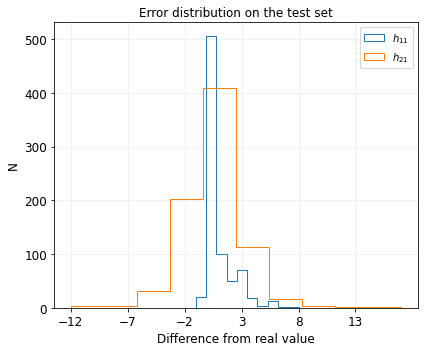

2020-04-01 18:43:40,958 --> INFO: Saving the estimator to el_net_h11.joblib.xz...
2020-04-01 18:43:40,992 --> INFO: Saved el_net_h11.joblib.xz!
2020-04-01 18:43:40,993 --> INFO: Saving the estimator to el_net_h21.joblib.xz...
2020-04-01 18:43:41,032 --> INFO: Saved el_net_h21.joblib.xz!


In [38]:
from sklearn.linear_model import ElasticNet
logprint('Evaluating Elastic Net...', logger=logger)

search_params = {'alpha':         Real(1e-6, 1e2, base=10, prior='log-uniform'),
                 'fit_intercept': Integer(False, True),
                 'normalize':     Integer(False, True)
                }
rounding = np.floor

# compute matrix baseline
logprint('Fitting the matrix baseline...', logger=logger)
el_net_h11 = BayesSearchCV(ElasticNet(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
el_net_h11.fit(matrix_train, h11_train)
gridcv_score(el_net_h11, rounding=rounding, logger=logger)
prediction_score(el_net_h11, matrix_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

el_net_h21 = BayesSearchCV(ElasticNet(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
el_net_h21.fit(matrix_train, h21_train)
gridcv_score(el_net_h21, rounding=rounding, logger=logger)
prediction_score(el_net_h21, matrix_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute num_cp baseline
logprint('Fitting the num_cp baseline...', logger=logger)
el_net_h11 = BayesSearchCV(ElasticNet(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
el_net_h11.fit(np.reshape(num_cp_train, (-1,1)), h11_train)
gridcv_score(el_net_h11, rounding=rounding, logger=logger)
prediction_score(el_net_h11, np.reshape(num_cp_test, (-1,1)), h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

el_net_h21 = BayesSearchCV(ElasticNet(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
el_net_h21.fit(np.reshape(num_cp_train, (-1,1)), h21_train)
gridcv_score(el_net_h21, rounding=rounding, logger=logger)
prediction_score(el_net_h21, np.reshape(num_cp_test, (-1,1)), h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute dim_cp baseline
logprint('Fitting the dim_cp baseline...', logger=logger)
el_net_h11 = BayesSearchCV(ElasticNet(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
el_net_h11.fit(dim_cp_train, h11_train)
gridcv_score(el_net_h11, rounding=rounding, logger=logger)
prediction_score(el_net_h11, dim_cp_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

el_net_h21 = BayesSearchCV(ElasticNet(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
el_net_h21.fit(dim_cp_train, h21_train)
gridcv_score(el_net_h21, rounding=rounding, logger=logger)
prediction_score(el_net_h21, dim_cp_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute feature engineered dataset
logprint('Fitting the feature engineered dataset...', logger=logger)
el_net_h11 = BayesSearchCV(ElasticNet(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
el_net_h11.fit(features_h11_train, h11_train)
gridcv_score(el_net_h11, rounding=rounding, logger=logger)
prediction_score(el_net_h11, features_h11_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

el_net_h21 = BayesSearchCV(ElasticNet(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
el_net_h21.fit(features_h21_train, h21_train)
gridcv_score(el_net_h21, rounding=rounding, logger=logger)
prediction_score(el_net_h21, features_h21_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# plot the error difference of the feature engineered dataset
logprint('Plotting error distribution...', logger=logger)
xplots  = 1
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

count_plot(ax,
           error_diff(h11_test,
                      el_net_h11.best_estimator_.predict(features_h11_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{11}$')
count_plot(ax,
           error_diff(h21_test,
                      el_net_h21.best_estimator_.predict(features_h21_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{21}$')

save_fig('el_net_error_eng', logger=logger)
plt.show()
plt.close(fig)

# Saving the feature engineered models
save_model('el_net_h11', el_net_h11.best_estimator_)
save_model('el_net_h21', el_net_h21.best_estimator_)

### LinearSVR

2020-04-01 18:43:41,081 --> INFO: Evaluating Linear SVR...
2020-04-01 18:43:41,084 --> INFO: Fitting the matrix baseline...
2020-04-01 18:54:58,463 --> INFO: Best parameters: OrderedDict([('C', 0.22717755440701617), ('fit_intercept', 0), ('intercept_scaling', 100.0), ('loss', 'squared_epsilon_insensitive')])
2020-04-01 18:54:58,465 --> INFO: Accuracy (floor) of cross-validation: (51.083 ± 1.878)%
2020-04-01 18:54:58,480 --> INFO: Accuracy (floor) of the predictions: 50.254%
2020-04-01 19:03:36,174 --> INFO: Best parameters: OrderedDict([('C', 10.899492556460192), ('fit_intercept', 1), ('intercept_scaling', 1.051173719939558), ('loss', 'epsilon_insensitive')])
2020-04-01 19:03:36,174 --> INFO: Accuracy (floor) of cross-validation: (11.309 ± 0.787)%
2020-04-01 19:03:36,183 --> INFO: Accuracy (floor) of the predictions: 12.723%
2020-04-01 19:03:36,184 --> INFO: Fitting the num_cp baseline...
2020-04-01 19:07:39,501 --> INFO: Best parameters: OrderedDict([('C', 0.07527780158455252), ('fit_

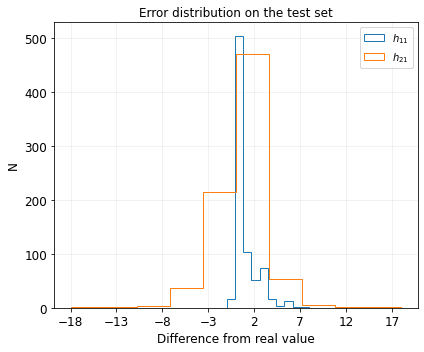

2020-04-01 20:25:56,957 --> INFO: Saving the estimator to lin_svr_h11.joblib.xz...
2020-04-01 20:25:56,990 --> INFO: Saved lin_svr_h11.joblib.xz!
2020-04-01 20:25:56,991 --> INFO: Saving the estimator to lin_svr_h21.joblib.xz...
2020-04-01 20:25:57,023 --> INFO: Saved lin_svr_h21.joblib.xz!


In [39]:
from sklearn.svm import LinearSVR
logprint('Evaluating Linear SVR...', logger=logger)

search_params = {'C':                 Real(1e-4, 1e4, base=10, prior='log-uniform'),
                 'intercept_scaling': Real(1e-2, 1e2, base=10, prior='log-uniform'),
                 'fit_intercept':     Integer(False, True),
                 'loss':              Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'])
                }
rounding = np.floor

# compute matrix baseline
logprint('Fitting the matrix baseline...', logger=logger)
lin_svr_h11 = BayesSearchCV(LinearSVR(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_svr_h11.fit(matrix_train, h11_train)
gridcv_score(lin_svr_h11, rounding=rounding, logger=logger)
prediction_score(lin_svr_h11, matrix_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lin_svr_h21 = BayesSearchCV(LinearSVR(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_svr_h21.fit(matrix_train, h21_train)
gridcv_score(lin_svr_h21, rounding=rounding, logger=logger)
prediction_score(lin_svr_h21, matrix_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute num_cp baseline
logprint('Fitting the num_cp baseline...', logger=logger)
lin_svr_h11 = BayesSearchCV(LinearSVR(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_svr_h11.fit(np.reshape(num_cp_train, (-1,1)), h11_train)
gridcv_score(lin_svr_h11, rounding=rounding, logger=logger)
prediction_score(lin_svr_h11, np.reshape(num_cp_test, (-1,1)), h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lin_svr_h21 = BayesSearchCV(LinearSVR(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_svr_h21.fit(np.reshape(num_cp_train, (-1,1)), h21_train)
gridcv_score(lin_svr_h21, rounding=rounding, logger=logger)
prediction_score(lin_svr_h21, np.reshape(num_cp_test, (-1,1)), h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute dim_cp baseline
logprint('Fitting the dim_cp baseline...', logger=logger)
lin_svr_h11 = BayesSearchCV(LinearSVR(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_svr_h11.fit(dim_cp_train, h11_train)
gridcv_score(lin_svr_h11, rounding=rounding, logger=logger)
prediction_score(lin_svr_h11, dim_cp_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lin_svr_h21 = BayesSearchCV(LinearSVR(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_svr_h21.fit(dim_cp_train, h21_train)
gridcv_score(lin_svr_h21, rounding=rounding, logger=logger)
prediction_score(lin_svr_h21, dim_cp_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute feature engineered dataset
logprint('Fitting the feature engineered dataset...', logger=logger)
lin_svr_h11 = BayesSearchCV(LinearSVR(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_svr_h11.fit(features_h11_train, h11_train)
gridcv_score(lin_svr_h11, rounding=rounding, logger=logger)
prediction_score(lin_svr_h11, features_h11_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

lin_svr_h21 = BayesSearchCV(LinearSVR(max_iter=15000, tol=0.001, random_state=RAND), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
lin_svr_h21.fit(features_h21_train, h21_train)
gridcv_score(lin_svr_h21, rounding=rounding, logger=logger)
prediction_score(lin_svr_h21, features_h21_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# plot the error difference of the feature engineered dataset
logprint('Plotting error distribution...', logger=logger)
xplots  = 1
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

count_plot(ax,
           error_diff(h11_test,
                      lin_svr_h11.best_estimator_.predict(features_h11_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{11}$')
count_plot(ax,
           error_diff(h21_test,
                      lin_svr_h21.best_estimator_.predict(features_h21_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{21}$')

save_fig('lin_svr_error_eng', logger=logger)
plt.show()
plt.close(fig)

# Saving the feature engineered models
save_model('lin_svr_h11', lin_svr_h11.best_estimator_)
save_model('lin_svr_h21', lin_svr_h21.best_estimator_)

### SVR

2020-04-01 20:25:57,052 --> INFO: Evaluating SVR...
2020-04-01 20:25:57,055 --> INFO: Fitting the matrix baseline...
2020-04-02 02:15:35,648 --> INFO: Best parameters: OrderedDict([('C', 17.101898070897082), ('epsilon', 4.123596483434236e-05), ('gamma', 0.05314914577792239), ('shrinking', 0)])
2020-04-02 02:15:35,650 --> INFO: Accuracy (rint) of cross-validation: (70.106 ± 1.368)%
2020-04-02 02:15:36,865 --> INFO: Accuracy (rint) of the predictions: 71.756%
2020-04-02 07:27:05,220 --> INFO: Best parameters: OrderedDict([('C', 10000.0), ('epsilon', 0.0015415535852746323), ('gamma', 0.09675780279196823), ('shrinking', 0)])
2020-04-02 07:27:05,221 --> INFO: Accuracy (rint) of cross-validation: (20.028 ± 1.271)%
2020-04-02 07:27:06,470 --> INFO: Accuracy (rint) of the predictions: 21.628%
2020-04-02 07:27:06,471 --> INFO: Fitting the num_cp baseline...
2020-04-02 07:40:47,137 --> INFO: Best parameters: OrderedDict([('C', 66.46771399077976), ('epsilon', 0.029185275973814057), ('gamma', 0.14

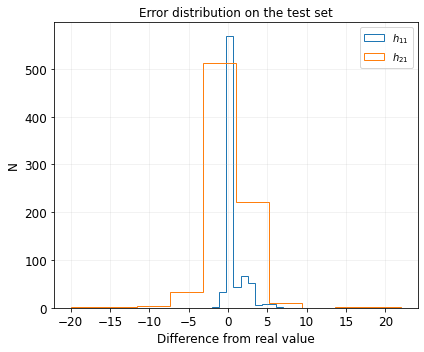

2020-04-02 16:06:18,550 --> INFO: Saving the estimator to svr_rbf_h11.joblib.xz...
2020-04-02 16:06:19,745 --> INFO: Saved svr_rbf_h11.joblib.xz!
2020-04-02 16:06:19,746 --> INFO: Saving the estimator to svr_rbf_h21.joblib.xz...
2020-04-02 16:06:21,234 --> INFO: Saved svr_rbf_h21.joblib.xz!


In [40]:
from sklearn.svm import SVR
logprint('Evaluating SVR...', logger=logger)

search_params = {'C':         Real(1e-4, 1e4, base=10, prior='log-uniform'),
                 'gamma':     Real(1e-6, 1e2, base=10, prior='log-uniform'),
                 'epsilon':   Real(1e-5, 1e1, base=10, prior='log-uniform'),
                 'shrinking': Integer(False, True)
                }
rounding = np.rint

# compute matrix baseline
logprint('Fitting the matrix baseline...', logger=logger)
svr_rbf_h11 = BayesSearchCV(SVR(kernel='rbf', tol=0.001), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
svr_rbf_h11.fit(matrix_train, h11_train)
gridcv_score(svr_rbf_h11, rounding=rounding, logger=logger)
prediction_score(svr_rbf_h11, matrix_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

svr_rbf_h21 = BayesSearchCV(SVR(kernel='rbf', tol=0.001), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
svr_rbf_h21.fit(matrix_train, h21_train)
gridcv_score(svr_rbf_h21, rounding=rounding, logger=logger)
prediction_score(svr_rbf_h21, matrix_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute num_cp baseline
logprint('Fitting the num_cp baseline...', logger=logger)
svr_rbf_h11 = BayesSearchCV(SVR(kernel='rbf', tol=0.001), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
svr_rbf_h11.fit(np.reshape(num_cp_train, (-1,1)), h11_train)
gridcv_score(svr_rbf_h11, rounding=rounding, logger=logger)
prediction_score(svr_rbf_h11, np.reshape(num_cp_test, (-1,1)), h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

svr_rbf_h21 = BayesSearchCV(SVR(kernel='rbf', tol=0.001), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
svr_rbf_h21.fit(np.reshape(num_cp_train, (-1,1)), h21_train)
gridcv_score(svr_rbf_h21, rounding=rounding, logger=logger)
prediction_score(svr_rbf_h21, np.reshape(num_cp_test, (-1,1)), h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute dim_cp baseline
logprint('Fitting the dim_cp baseline...', logger=logger)
svr_rbf_h11 = BayesSearchCV(SVR(kernel='rbf', tol=0.001), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
svr_rbf_h11.fit(dim_cp_train, h11_train)
gridcv_score(svr_rbf_h11, rounding=rounding, logger=logger)
prediction_score(svr_rbf_h11, dim_cp_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

svr_rbf_h21 = BayesSearchCV(SVR(kernel='rbf', tol=0.001), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
svr_rbf_h21.fit(dim_cp_train, h21_train)
gridcv_score(svr_rbf_h21, rounding=rounding, logger=logger)
prediction_score(svr_rbf_h21, dim_cp_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute feature engineered dataset
logprint('Fitting the feature engineered dataset...', logger=logger)
svr_rbf_h11 = BayesSearchCV(SVR(kernel='rbf', tol=0.001), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
svr_rbf_h11.fit(features_h11_train, h11_train)
gridcv_score(svr_rbf_h11, rounding=rounding, logger=logger)
prediction_score(svr_rbf_h11, features_h11_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

svr_rbf_h21 = BayesSearchCV(SVR(kernel='rbf', tol=0.001), search_params, n_iter=n_iter, scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
svr_rbf_h21.fit(features_h21_train, h21_train)
gridcv_score(svr_rbf_h21, rounding=rounding, logger=logger)
prediction_score(svr_rbf_h21, features_h21_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# plot the error difference of the feature engineered dataset
logprint('Plotting error distribution...', logger=logger)
xplots  = 1
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

count_plot(ax,
           error_diff(h11_test,
                      svr_rbf_h11.best_estimator_.predict(features_h11_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{11}$')
count_plot(ax,
           error_diff(h21_test,
                      svr_rbf_h21.best_estimator_.predict(features_h21_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{21}$')

save_fig('svr_rbf_error_eng', logger=logger)
plt.show()
plt.close(fig)

# Saving the feature engineered models
save_model('svr_rbf_h11', svr_rbf_h11.best_estimator_)
save_model('svr_rbf_h21', svr_rbf_h21.best_estimator_)

### Random Forest

2020-04-02 19:44:45,867 --> INFO: Evaluating Random Forest...
2020-04-02 19:44:45,872 --> INFO: Fitting the matrix baseline...
2020-04-02 19:57:08,383 --> INFO: Best parameters: OrderedDict([('criterion', 'friedman_mse'), ('max_depth', 18), ('min_samples_leaf', 11), ('min_samples_split', 3), ('n_estimators', 45)])
2020-04-02 19:57:08,384 --> INFO: Accuracy (floor) of cross-validation: (59.038 ± 2.314)%
2020-04-02 19:57:08,494 --> INFO: Accuracy (floor) of the predictions: 58.779%
2020-04-02 20:16:37,516 --> INFO: Best parameters: OrderedDict([('criterion', 'mae'), ('max_depth', 16), ('min_samples_leaf', 9), ('min_samples_split', 7), ('n_estimators', 34)])
2020-04-02 20:16:37,516 --> INFO: Accuracy (floor) of cross-validation: (13.602 ± 1.183)%
2020-04-02 20:16:37,623 --> INFO: Accuracy (floor) of the predictions: 13.613%
2020-04-02 20:16:37,624 --> INFO: Fitting the num_cp baseline...
2020-04-02 20:17:07,341 --> INFO: Best parameters: OrderedDict([('criterion', 'mae'), ('max_depth', 14

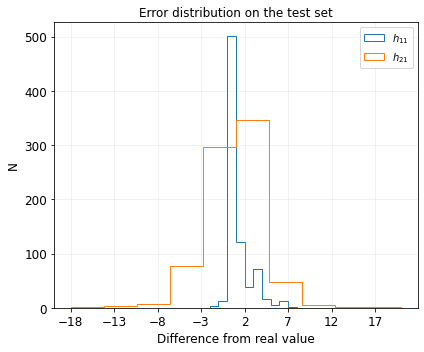

2020-04-03 00:10:34,993 --> INFO: Saving the estimator to rnd_for_h11.joblib.xz...
2020-04-03 00:10:35,130 --> INFO: Saved rnd_for_h11.joblib.xz!
2020-04-03 00:10:35,132 --> INFO: Saving the estimator to rnd_for_h21.joblib.xz...
2020-04-03 00:10:35,626 --> INFO: Saved rnd_for_h21.joblib.xz!


In [43]:
from sklearn.ensemble import RandomForestRegressor
logprint('Evaluating Random Forest...', logger=logger)

search_params = {'n_estimators':      Integer(2, 75, prior='uniform'),
                 'criterion':         Categorical(['friedman_mse', 'mae']),
                 'min_samples_split': Integer(2, 10, prior='uniform'),
                 'min_samples_leaf':  Integer(1, 50, prior='uniform'),
                 'max_depth':         Integer(2, 20, prior='uniform')
                }
rounding = np.floor

# compute matrix baseline
logprint('Fitting the matrix baseline...', logger=logger)
rnd_for_h11 = BayesSearchCV(RandomForestRegressor(n_jobs=-1, random_state=RAND), search_params, n_iter=int(n_iter/5), scoring=scorer(rounding), n_jobs=1, refit=True, cv=cv)
rnd_for_h11.fit(matrix_train, h11_train)
gridcv_score(rnd_for_h11, rounding=rounding, logger=logger)
prediction_score(rnd_for_h11, matrix_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

rnd_for_h21 = BayesSearchCV(RandomForestRegressor(n_jobs=-1, random_state=RAND), search_params, n_iter=int(n_iter/5), scoring=scorer(rounding), n_jobs=1, refit=True, cv=cv)
rnd_for_h21.fit(matrix_train, h21_train)
gridcv_score(rnd_for_h21, rounding=rounding, logger=logger)
prediction_score(rnd_for_h21, matrix_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute num_cp baseline
logprint('Fitting the num_cp baseline...', logger=logger)
rnd_for_h11 = BayesSearchCV(RandomForestRegressor(n_jobs=-1, random_state=RAND), search_params, n_iter=int(n_iter/5), scoring=scorer(rounding), n_jobs=1, refit=True, cv=cv)
rnd_for_h11.fit(np.reshape(num_cp_train, (-1,1)), h11_train)
gridcv_score(rnd_for_h11, rounding=rounding, logger=logger)
prediction_score(rnd_for_h11, np.reshape(num_cp_test, (-1,1)), h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

rnd_for_h21 = BayesSearchCV(RandomForestRegressor(n_jobs=-1, random_state=RAND), search_params, n_iter=int(n_iter/5), scoring=scorer(rounding), n_jobs=1, refit=True, cv=cv)
rnd_for_h21.fit(np.reshape(num_cp_train, (-1,1)), h21_train)
gridcv_score(rnd_for_h21, rounding=rounding, logger=logger)
prediction_score(rnd_for_h21, np.reshape(num_cp_test, (-1,1)), h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute dim_cp baseline
logprint('Fitting the dim_cp baseline...', logger=logger)
rnd_for_h11 = BayesSearchCV(RandomForestRegressor(n_jobs=-1, random_state=RAND), search_params, n_iter=int(n_iter/5), scoring=scorer(rounding), n_jobs=1, refit=True, cv=cv)
rnd_for_h11.fit(dim_cp_train, h11_train)
gridcv_score(rnd_for_h11, rounding=rounding, logger=logger)
prediction_score(rnd_for_h11, dim_cp_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

rnd_for_h21 = BayesSearchCV(RandomForestRegressor(n_jobs=-1, random_state=RAND), search_params, n_iter=int(n_iter/5), scoring=scorer(rounding), n_jobs=1, refit=True, cv=cv)
rnd_for_h21.fit(dim_cp_train, h21_train)
gridcv_score(rnd_for_h21, rounding=rounding, logger=logger)
prediction_score(rnd_for_h21, dim_cp_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# compute feature engineered dataset
logprint('Fitting the feature engineered dataset...', logger=logger)
rnd_for_h11 = BayesSearchCV(RandomForestRegressor(n_jobs=-1, random_state=RAND), search_params, n_iter=int(n_iter/5), scoring=scorer(rounding), n_jobs=1, refit=True, cv=cv)
rnd_for_h11.fit(features_h11_train, h11_train)
gridcv_score(rnd_for_h11, rounding=rounding, logger=logger)
prediction_score(rnd_for_h11, features_h11_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

rnd_for_h21 = BayesSearchCV(RandomForestRegressor(n_jobs=-1, random_state=RAND), search_params, n_iter=int(n_iter/5), scoring=scorer(rounding), n_jobs=1, refit=True, cv=cv)
rnd_for_h21.fit(features_h21_train, h21_train)
gridcv_score(rnd_for_h21, rounding=rounding, logger=logger)
prediction_score(rnd_for_h21, features_h21_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# plot the error difference of the feature engineered dataset
logprint('Plotting error distribution...', logger=logger)
xplots  = 1
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

count_plot(ax,
           error_diff(h11_test,
                      rnd_for_h11.best_estimator_.predict(features_h11_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{11}$')
count_plot(ax,
           error_diff(h21_test,
                      rnd_for_h21.best_estimator_.predict(features_h21_test),
                      rounding=rounding),
           title='Error distribution on the test set',
           xlabel='Difference from real value',
           legend='$h_{21}$')

save_fig('rnd_for_error_eng', logger=logger)
plt.show()
plt.close(fig)

# Saving the feature engineered models
save_model('rnd_for_h11', rnd_for_h11.best_estimator_)
save_model('rnd_for_h21', rnd_for_h21.best_estimator_)

### Gradient Boosting

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
logprint('Evaluating Gradient Boosting...', logger=logger)

search_params = {'loss':              Categorical(['ls', 'lad']),
                 'learning_rate':     Real(1e-4, 1e1, base=10, prior='log-uniform'),
                 'n_estimators':      Integer(100, 500, prior='uniform'),
                 'subsample':         Real(0.6, 1.0, prior='uniform'),
                 'criterion':         Categorical(['friedman_mse', 'mae']),
                 'min_samples_split': Integer(2, 10, prior='uniform'),
                 'min_samples_leaf':  Integer(1, 50, prior='uniform'),
                 'max_depth':         Integer(2, 20, prior='uniform')
                }
rounding = np.floor

# compute matrix baseline
logprint('Fitting the matrix baseline...', logger=logger)
grd_boost_h11 = BayesSearchCV(GradientBoostingRegressor(random_state=RAND), search_params, n_iter=int(n_iter/10), scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
grd_boost_h11.fit(matrix_train, h11_train)
gridcv_score(grd_boost_h11, rounding=rounding, logger=logger)
prediction_score(grd_boost_h11, matrix_test, h11_test, use_best_estimator=True, rounding=rounding, logger=logger)

grd_boost_h21 = BayesSearchCV(GradientBoostingRegressor(random_state=RAND), search_params, n_iter=int(n_iter/10), scoring=scorer(rounding), n_jobs=-1, refit=True, cv=cv)
grd_boost_h21.fit(matrix_train, h21_train)
gridcv_score(grd_boost_h21, rounding=rounding, logger=logger)
prediction_score(grd_boost_h21, matrix_test, h21_test, use_best_estimator=True, rounding=rounding, logger=logger)

# Saving the feature engineered models
save_model('grd_boost_matrix_h11', grd_boost_h11.best_estimator_)
save_model('grd_boost_matrix_h21', grd_boost_h21.best_estimator_)

2020-04-03 00:10:35,649 --> INFO: Evaluating Gradient Boosting...
2020-04-03 00:10:35,656 --> INFO: Fitting the matrix baseline...
2020-04-03 05:36:49,866 --> INFO: Best parameters: OrderedDict([('criterion', 'friedman_mse'), ('learning_rate', 0.01452537005139791), ('loss', 'lad'), ('max_depth', 14), ('min_samples_leaf', 48), ('min_samples_split', 3), ('n_estimators', 415), ('subsample', 0.8932502996114972)])
2020-04-03 05:36:49,867 --> INFO: Accuracy (floor) of cross-validation: (49.045 ± 2.407)%
2020-04-03 05:36:49,895 --> INFO: Accuracy (floor) of the predictions: 49.618%
2020-04-03 08:00:48,279 --> INFO: Best parameters: OrderedDict([('criterion', 'mae'), ('learning_rate', 0.060756456082053295), ('loss', 'lad'), ('max_depth', 17), ('min_samples_leaf', 21), ('min_samples_split', 4), ('n_estimators', 393), ('subsample', 0.6037614989874224)])
2020-04-03 08:00:48,280 --> INFO: Accuracy (floor) of cross-validation: (15.867 ± 1.559)%
2020-04-03 08:00:48,307 --> INFO: Accuracy (floor) of 

ValueError: cannot convert float NaN to integer

## Neural Networks

We then try to build a neural network (NN) architecture capable of predicting $h_{11}$ and $h_{21}$. We start from a simple sequential model to predict the Hodge numbers separately and then build more complicated structures to improve the predictions. The approach will be to use the configuration matrix through a _Convolutional Neural Network_ to handle the regression task (we append a fully connected (FC) network at the end of the convolutions to predict one number).

In [45]:
from tensorflow.keras            import Input
from tensorflow.keras.models     import Model
from tensorflow.keras.layers     import Conv2D, MaxPool2D, AvgPool2D, concatenate, Flatten, Dense, BatchNormalization, Dropout, LeakyReLU, Lambda
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils      import plot_model
from tensorflow.keras.callbacks  import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# load the dataset
DF_MAT_PATH = path.join(ROOT_DIR, 'cicy3o_matrix.h5.zip')
if path.isfile(DF_MAT_PATH):
    df      = load_dataset(DF_MAT_PATH, shuffle=True, random_state=RAND, logger=logger)
    
    # extract labels and features
    df_labs = df[['h11', 'h21']]
    df_feat = df.drop(labels=['h11', 'h21'], axis=1)
    
    # divide features according to training sets
    logprint('Extracting features from the matrix database...', logger=logger)
    matrix = ExtractTensor(flatten=False).fit_transform(df_feat['matrix'])
    matrix = np.reshape(matrix, np.shape(matrix) + (1,)) # reshape matrix for convolutional layers
    logprint('Features extracted!', logger=logger)
else:
    logprint('File is not present: cannot read matrix database!', stream='error', logger=logger)
    
# split into training and test sets
logprint('Splitting dataset into training and test sets...', logger=logger)
matrix_train, matrix_test, h11_train, h11_test, h21_train, h21_test = train_test_split(matrix, df_labs['h11'].values, df_labs['h21'].values, test_size=0.1, shuffle=True, random_state=RAND)
logprint('Splitting dataset into training and validation sets...', logger=logger)
matrix_train, matrix_val, h11_train, h11_val, h21_train, h21_val = train_test_split(matrix_train, h11_train, h21_train, test_size=1.0/9.0, shuffle=True, random_state=RAND)
logprint('Splitting complete!', logger=logger)

2020-04-03 08:44:09,488 --> INFO: Reading database...
2020-04-03 08:44:09,555 --> INFO: Database loaded!
2020-04-03 08:44:09,555 --> INFO: Shuffling database...
2020-04-03 08:44:09,559 --> INFO: Database shuffled!
2020-04-03 08:44:09,569 --> INFO: Extracting features from the matrix database...
2020-04-03 08:44:09,988 --> INFO: Features extracted!
2020-04-03 08:44:09,990 --> INFO: Splitting dataset into training and test sets...
2020-04-03 08:44:09,997 --> INFO: Splitting dataset into training and validation sets...
2020-04-03 08:44:10,001 --> INFO: Splitting complete!


We then build the architecture:

In [46]:
def build_conv_model(input_shape,
                     leaky=0.3,
                     dropout=0.5
                    ):
    """Builds a convolutional model using Keras.
    
    Required arguments:
        input_shape: the shape of the input layer
    
    Optional arguments:
        leaky:   the amount of leak of the LeakyReLU activation
        dropout: the rate of dropout
        
    Returns:
        the model
    """
    
    # input layer
    start = Input(shape=input_shape)
    
    # convnet
    cv = Conv2D(filters=80, kernel_size=(5,6), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1(0.001))(start)
    cv = Conv2D(filters=40, kernel_size=(5,6), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1(0.001))(cv)
    cv = Conv2D(filters=20, kernel_size=(5,6), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.l1(0.001))(cv)
    
    # fully connected
    fc = Flatten()(cv)
    fc = Dense(800, activation='relu')(fc)
    
    # output layer
    end = Dense(1, activation='relu')(fc) # output layer (regression task => 1 neuron)
    
    # build the model
    model = Model(inputs=start, outputs=end)
    
    return model

Then we analyse it:

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 15, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 12, 15, 80)        2480      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 15, 40)        96040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 15, 20)        24020     
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dense (Dense)                (None, 800)               2880800   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 801   

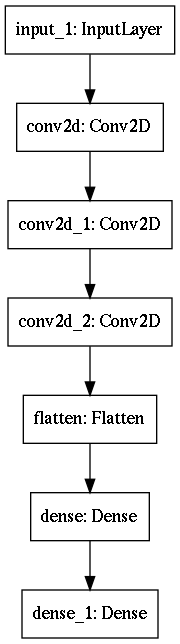

In [47]:
model_h11 = build_conv_model(input_shape=matrix.shape[1:], leaky=5.5, dropout=0.5)

# print a summary and plot the model
model_h11.summary()
plot_model(model_h11, to_file=path.join(IMG_PATH, 'conv_model.png'), dpi=96)

And compile it:

In [51]:
# use callbacks (NB: early stopping with restore_best_weights=True does not need to reload the model from file)
patience  = 50
callbacks = [ModelCheckpoint(filepath=path.join(MOD_PATH, 'conv_model.h5'), monitor='val_mean_squared_error', verbose=1, save_best_only=True, save_weights_only=True),
             EarlyStopping(monitor='val_mean_squared_error', patience=patience, verbose=1, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.3, patience=patience/2, verbose=1)
            ]
# optimizer = Adam(learning_rate=0.01, amsgrad=False)
# optimizer = Adam(learning_rate=0.01, amsgrad=True)
optimizer = SGD(learning_rate=0.001, momentum=0.9)

model_h11.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

logprint('Evaluating ConvNet...', logger=logger)
model_h11_history = model_h11.fit(x=matrix_train, y=h11_train, batch_size=32, epochs=1000, callbacks=callbacks, validation_data=(matrix_val, h11_val))

2020-04-03 09:16:04,582 --> INFO: Evaluating ConvNet...
Train on 6280 samples, validate on 785 samples
Epoch 1/1000
6272/6280 [============================>.] - ETA: 0s - loss: 0.1937 - mean_squared_error: 0.0634
Epoch 00001: val_mean_squared_error improved from inf to 0.31814, saving model to ./models/original/conv_model.h5
6280/6280 [==============================] - 5s 768us/sample - loss: 0.1936 - mean_squared_error: 0.0633 - val_loss: 0.4487 - val_mean_squared_error: 0.3181
Epoch 2/1000
6240/6280 [============================>.] - ETA: 0s - loss: 0.1936 - mean_squared_error: 0.0632
Epoch 00002: val_mean_squared_error did not improve from 0.31814
6280/6280 [==============================] - 4s 690us/sample - loss: 0.1937 - mean_squared_error: 0.0633 - val_loss: 0.4622 - val_mean_squared_error: 0.3319
Epoch 3/1000
6272/6280 [============================>.] - ETA: 0s - loss: 0.2001 - mean_squared_error: 0.0696
Epoch 00003: val_mean_squared_error did not improve from 0.31814
6280/6280

We then plot metrics and loss during training:

2020-04-03 09:22:38,796 --> INFO: Saving ./img/original/conv_model_loss_metric.png...
2020-04-03 09:22:38,951 --> INFO: Saved ./img/original/conv_model_loss_metric.png!


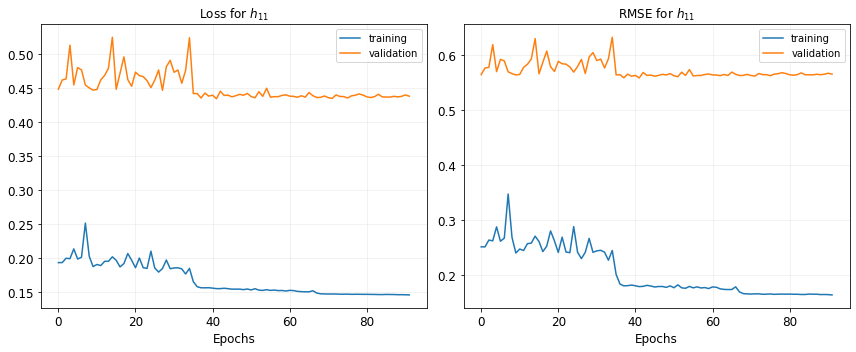

2020-04-03 09:22:39,398 --> INFO: Evaluating model: loss = 0.435, mse = 0.311 => rmse = 0.558
2020-04-03 09:22:39,612 --> INFO: Accuracy (rint) of the predictions: 80.255%


In [52]:
# recover data
data_h11 = model_h11_history.history

# plot data
xplots  = 2
yplots  = 1
fig, ax = plt.subplots(yplots, xplots, figsize=(xplots*mpl_width, yplots*mpl_height))
fig.tight_layout()

series_plot(ax[0], data_h11['loss'],     title='Loss for $h_{11}$', xlabel='Epochs', legend='training')
series_plot(ax[0], data_h11['val_loss'], title='Loss for $h_{11}$', xlabel='Epochs', legend='validation')

series_plot(ax[1], np.sqrt(data_h11['mean_squared_error']),     title='RMSE for $h_{11}$', xlabel='Epochs', legend='training')
series_plot(ax[1], np.sqrt(data_h11['val_mean_squared_error']), title='RMSE for $h_{11}$', xlabel='Epochs', legend='validation')

save_fig('conv_model_loss_metric', logger=logger)
plt.show()
plt.close(fig)

# evaluate the model on the validation set
evaluation_h11 = model_h11.evaluate(x=matrix_val, y=h11_val, verbose=0)
logprint('Evaluating model: loss = {:.3f}, mse = {:.3f} => rmse = {:.3f}'.format(evaluation_h11[0], evaluation_h11[1], np.sqrt(evaluation_h11[1])), logger=logger)

# compute accuracy of the model on the validation set
prediction_score(model_h11, X=matrix_val.astype(np.float16), y=h11_val, use_best_estimator=False, logger=logger)

Then we can make some predictions:

In [53]:
# evaluate the model
evaluation_h11 = model_h11.evaluate(x=matrix_test, y=h11_test, verbose=0)
logprint('Evaluating model: loss = {:.3f}, mse = {:.3f} => rmse = {:.3f}'.format(evaluation_h11[0], evaluation_h11[1], np.sqrt(evaluation_h11[1])), logger=logger)

# compute accuracy of the model
prediction_score(model_h11, X=matrix_test.astype(np.float16), y=h11_test, use_best_estimator=False, logger=logger)

2020-04-03 09:22:39,820 --> INFO: Evaluating model: loss = 0.427, mse = 0.304 => rmse = 0.551
2020-04-03 09:22:39,997 --> INFO: Accuracy (rint) of the predictions: 81.934%
